<center size=vw>
<strong><font size=10>Spotify genre classification</font></strong>
</br>

</center>


In [1]:
# system information
import time

# data analysis
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
cross_val_score, StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
      GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, precision_score, accuracy_score, \
f1_score, average_precision_score, precision_recall_curve, make_scorer
from sklearn.metrics import confusion_matrix
from itertools import cycle

# 1. Exploratory Data Analysis

In [2]:
df = pd.read_csv('top10s.csv', encoding='latin-1')
df.head()

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


En aquesta primera visualització de les dades, ja es pot veure que la primera columna s'haurà d'eliminar, ja que és un índex irrellevant per l'anàlisi. També podem observar que tenim 3 features categòriques que s'hauràn de tractar posteriorment.

Per a fer més entendibles les dades canvio el nom de certes columnes i elimino l'índex innecessari.

In [3]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.rename(columns = {'top genre': 'top_genre', 'bpm': 'beats_per_minute', 'nrgy': 'energy',
                       'dnce': 'danceability', 'dB': 'loudness_dB', 'live': 'liveness',
                       'val': 'positivity', 'dur': 'length', 'acous': 'acousticness',
                       'spch': 'speechiness', 'pop': 'popularity'}, inplace=True)

In [4]:
# Comprovacio de NaNs
df.isnull().sum()

title               0
artist              0
top_genre           0
year                0
beats_per_minute    0
energy              0
danceability        0
loudness_dB         0
liveness            0
positivity          0
length              0
acousticness        0
speechiness         0
popularity          0
dtype: int64

Amb aquesta informació, ja es pot veure que aquest dataset no té NaNs i per tant no caldrà fer el seu posterior tractament.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             603 non-null    object
 1   artist            603 non-null    object
 2   top_genre         603 non-null    object
 3   year              603 non-null    int64 
 4   beats_per_minute  603 non-null    int64 
 5   energy            603 non-null    int64 
 6   danceability      603 non-null    int64 
 7   loudness_dB       603 non-null    int64 
 8   liveness          603 non-null    int64 
 9   positivity        603 non-null    int64 
 10  length            603 non-null    int64 
 11  acousticness      603 non-null    int64 
 12  speechiness       603 non-null    int64 
 13  popularity        603 non-null    int64 
dtypes: int64(11), object(3)
memory usage: 66.1+ KB


En quant a les features, ja s'ha vist que n'hi ha 14. Les quals es poden classificar en:

*   **Numèriques**:
    * <u>Discretes</u>: year, beats_per_minute, energy, danceability, loudness_dB, liveness, positivity, length, acousticness, spechiness i popularity.
*   **Categòriques**:
    * <u>Nominals</u>: title, artist i top_genre.
  


In [6]:
# Descripcio mes amplia de les caracteristiques numeriques
df.describe()

,year,beats_per_minute,energy,danceability,loudness_dB,liveness,positivity,length,acousticness,speechiness,popularity
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,2014.592040,118.545605,70.504146,64.379768,-5.578773,17.774461,52.225539,224.674959,14.326700,8.358209,66.520730
std,2.607057,24.795358,16.310664,13.378718,2.798020,13.102543,22.513020,34.130059,20.766165,7.483162,14.517746
min,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000
25%,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,60.000000
50%,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,221.000000,6.000000,5.000000,69.000000
75%,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.500000,17.000000,9.000000,76.000000
max,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,99.000000


D'aquesta descripció més amplia, es pot observar que les pulsacions per minut o el temps de la cançó (beats_per_minute), el seu valor mínim és de 0. Això serà un possible valor atípic o outlier que s'haurà de modificar, ja que inclús les cançons més lentes tenen ritme.

In [7]:
# Busco quantes files contenen aquest outlier
df[df['beats_per_minute'] == 0]

,title,artist,top_genre,year,beats_per_minute,energy,danceability,loudness_dB,liveness,positivity,length,acousticness,speechiness,popularity
442,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,0,0,0


<Axes: >

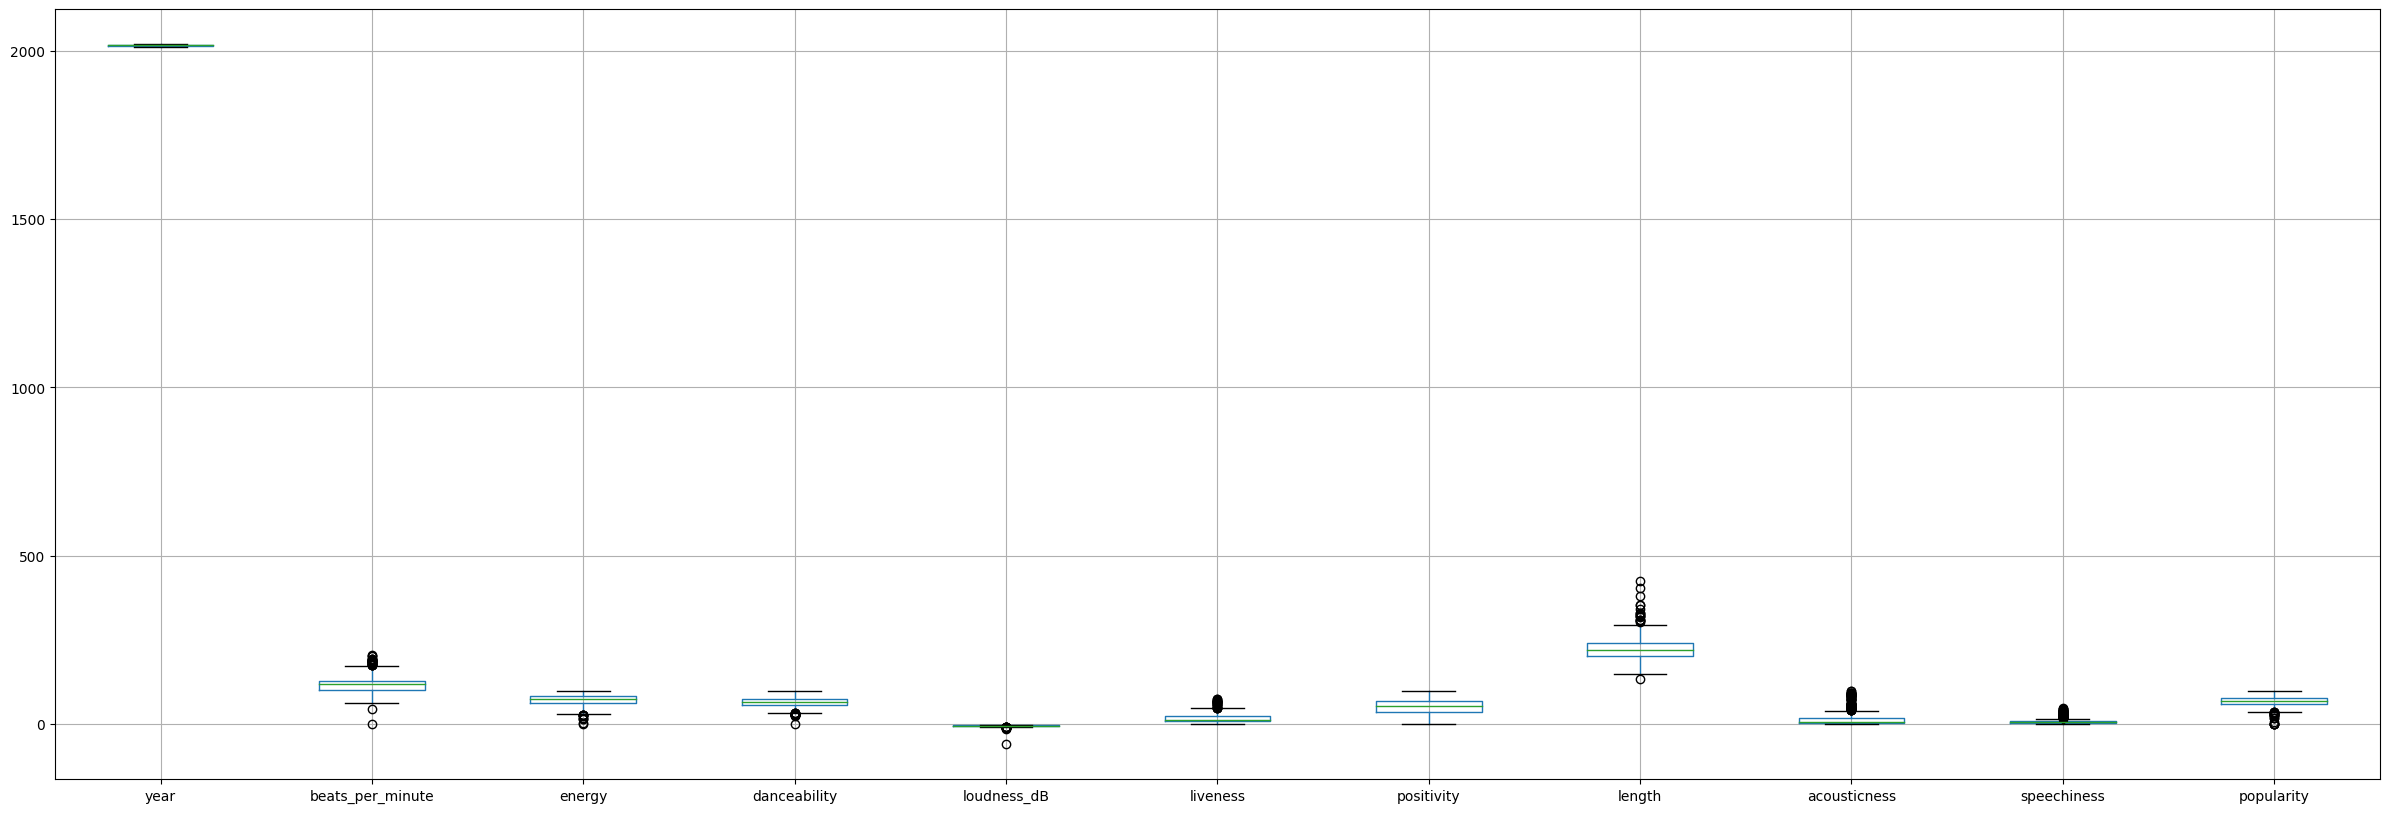

In [8]:
# Comprovo els valors de la resta de caracteristiques
plt.rcParams['figure.figsize'] = 30, 10
df.select_dtypes(include=np.number).boxplot()

<Axes: >

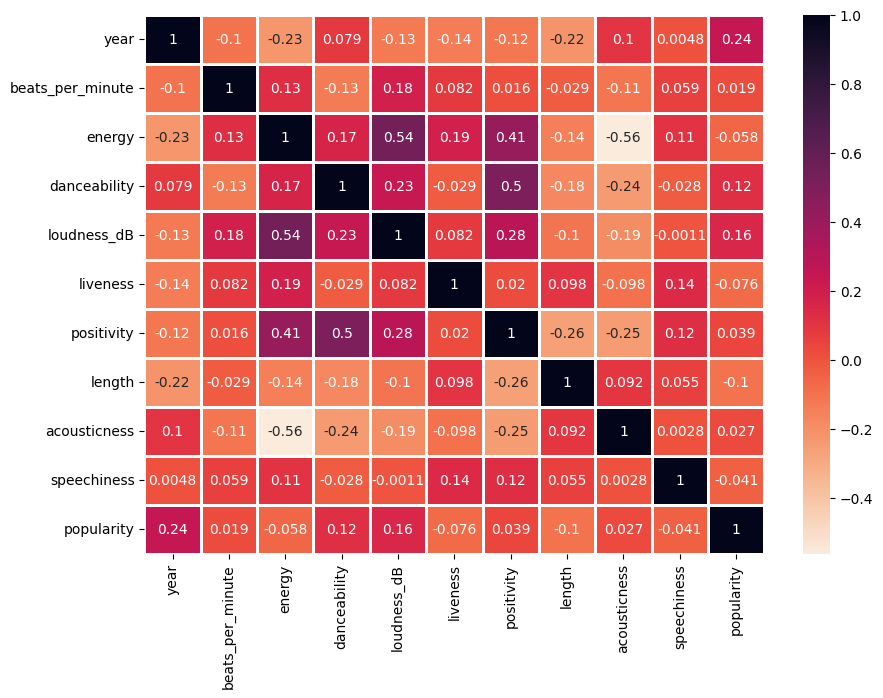

In [9]:
# Heatmap de les correlacions entre features
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap="rocket_r", linewidths=2)

Hi ha una forta correlació entre (loudness_dB /
energy), (positivity / danceability), (positivity / energy), (positivity / loudness_dB) i (positivity / year).
Per altra banda, acousticness i energy estàn molt poc correlacionades.

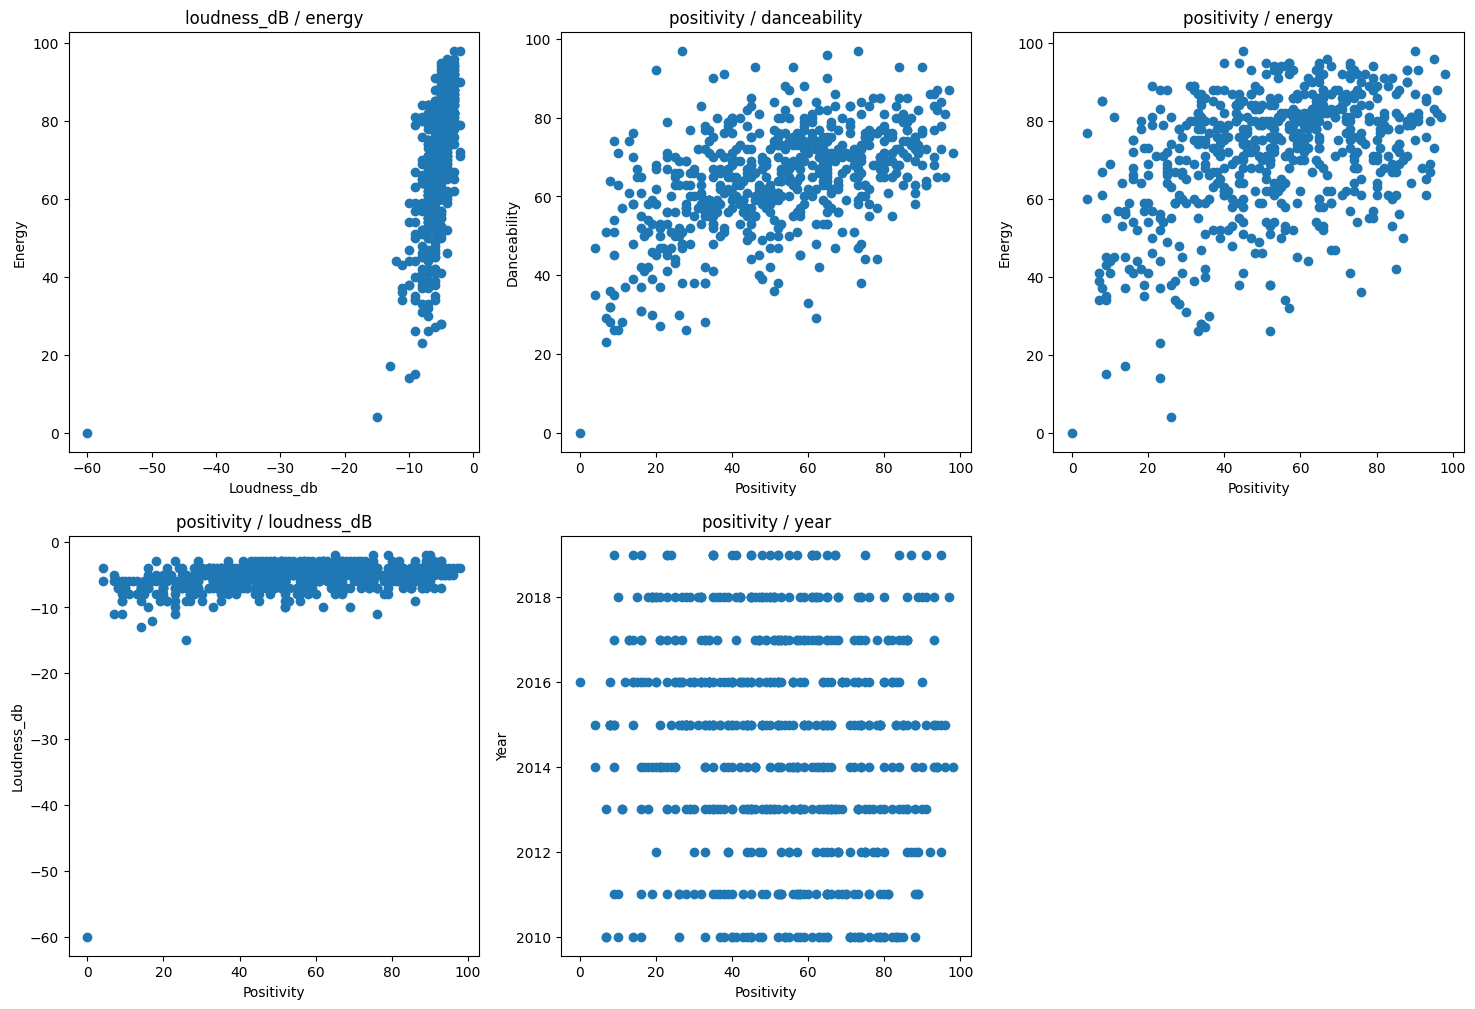

In [10]:
# Correlacions
features = [('loudness_dB', 'energy'),
            ('positivity', 'danceability'),
            ('positivity', 'energy'),
            ('positivity', 'loudness_dB'),
            ('positivity', 'year')]

# Tituls dels grafics
titles = ['loudness_dB / energy',
          'positivity / danceability',
          'positivity / energy',
          'positivity / loudness_dB',
          'positivity / year']

# Figura amb els subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i, ((x, y), title) in enumerate(zip(features, titles)):
    # Selecciono el subplot adequat
    ax = axs[i // 3][i % 3]

    # Creo els grafics de dispersio
    ax.scatter(df[x], df[y])

    # Etiquetes
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y.capitalize())
    ax.set_title(title)

# Elimino el ultim subplot buit, si els grafics son impars (com es el cas)
if len(features) % 2 != 0:
    fig.delaxes(axs[-1, -1])

plt.show()



*   Com més energètica és la cançó, més positiva és.
*   Les cançons més positives, són més ballables.



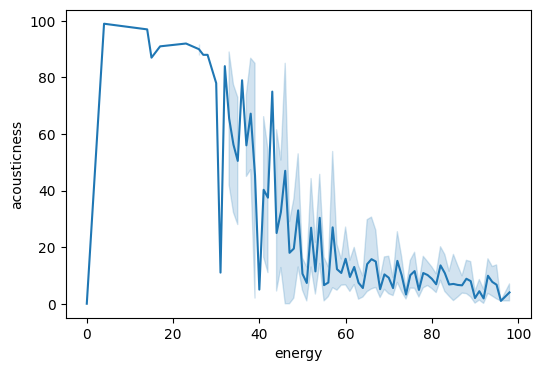

In [11]:
#  Acousticness i energy
plt.figure(figsize=(6, 4))
sns.lineplot(x="energy", y="acousticness", data=df)
plt.show()

Sembla a ser que acousticness acostuma a tenir una relació inversament proporcional a energy, ja que com més acústica és la cançó, tendeix a ser menys energètica.

In [12]:
# Descripcio mes amplia de les caracteristiques categoriques
df.describe(include=['O'])

,title,artist,top_genre
count,603,603,603
unique,584,184,50
top,A Little Party Never Killed Nobody (All We Got),Katy Perry,dance pop
freq,2,17,327


Tal com es mostra, hi ha 50 gèneres de música (els quals s'hauran d'agrupar i tractar posteriorment) i hi ha 584/603 cançons úniques (probablement hi hauran repetides i haurem d'eliminar-les).

In [13]:
# Comprovo si realment hi ha cançons repetides amb el titol i el autor
duplicated_songs = df.duplicated(subset=['title', 'artist'], keep=False)
df[duplicated_songs].sort_values(by='title')

,title,artist,top_genre,year,beats_per_minute,energy,danceability,loudness_dB,liveness,positivity,length,acousticness,speechiness,popularity
178,A Little Party Never Killed Nobody (All We Got),Fergie,dance pop,2013,130,62,76,-6,9,52,241,1,18,65
239,A Little Party Never Killed Nobody (All We Got),Fergie,dance pop,2014,130,62,76,-6,9,52,241,1,18,65
473,All I Ask,Adele,british soul,2017,142,28,59,-5,15,34,272,88,3,71
398,All I Ask,Adele,british soul,2016,142,28,59,-5,15,34,272,88,3,71
48,Castle Walls (feat. Christina Aguilera),T.I.,atl hip hop,2010,80,86,45,-5,26,58,329,7,39,49
95,Castle Walls (feat. Christina Aguilera),T.I.,atl hip hop,2011,80,86,45,-5,26,58,329,7,39,49
396,Company,Justin Bieber,canadian pop,2016,95,80,59,-5,8,43,208,13,6,72
301,Company,Justin Bieber,canadian pop,2015,95,80,59,-5,8,43,208,13,6,72
474,First Time,Kygo,edm,2017,90,59,63,-7,10,68,194,20,11,71
548,First Time,Kygo,edm,2018,90,59,63,-7,10,68,194,20,11,71


Com es pot veure, n'hi ha cançons que es repeteixen un cop, però tot i ser de diferents anys és la mateixa música, ja que la durada, la popularitat i la resta de característiques són idèntiques i, per tant, s'hauran d'eliminar més endavant.

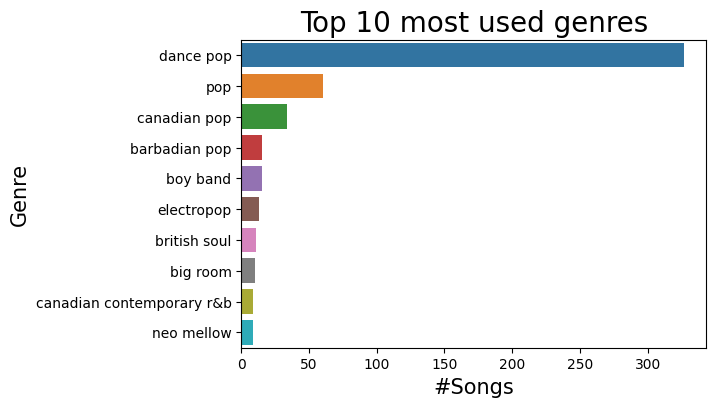

In [14]:
# Aproximacio de quins son els 10 generes que mes s'utilitzen
plt.figure(figsize=(6, 4))
most_used = df['top_genre'].value_counts().head(10)
sns.barplot(x=most_used.values, y=most_used.index)
plt.title('Top 10 most used genres',fontsize=20)
plt.ylabel('Genre', fontsize=15)
plt.xlabel('#Songs', fontsize=15)
plt.show()
plt.show()

Es pot observar, que a partir del neo mellow, la resta de gèneres són molt poc utilitzats. Amplio la llista de tots els generes, per tenir una visió més amplia.

In [15]:
# Ampliacio dels generes mes utilitzats
df['top_genre'].value_counts()

dance pop                    327
pop                           60
canadian pop                  34
barbadian pop                 15
boy band                      15
electropop                    13
british soul                  11
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
complextro                     6
hip pop                        6
australian dance               6
atl hip hop                    5
australian pop                 5
edm                            5
permanent wave                 4
latin                          4
hip hop                        4
colombian pop                  3
tropical house                 3
brostep                        2
downtempo                      2
electronic trap                2
belgian edm                    2
escape room                    2
folk-pop                       2
electro                        2
indie pop                      2
detroit hi

Hi ha molts gèneres que sols s'utilitzen una o dues vegades que s'hauran d'eliminar o agrupar posteriorment.

Per tenir una primera impressió d'aquests gèneres amb la resta de característiques, faig un plot de les features i el target (dels 10 gèneres més utilitzats).

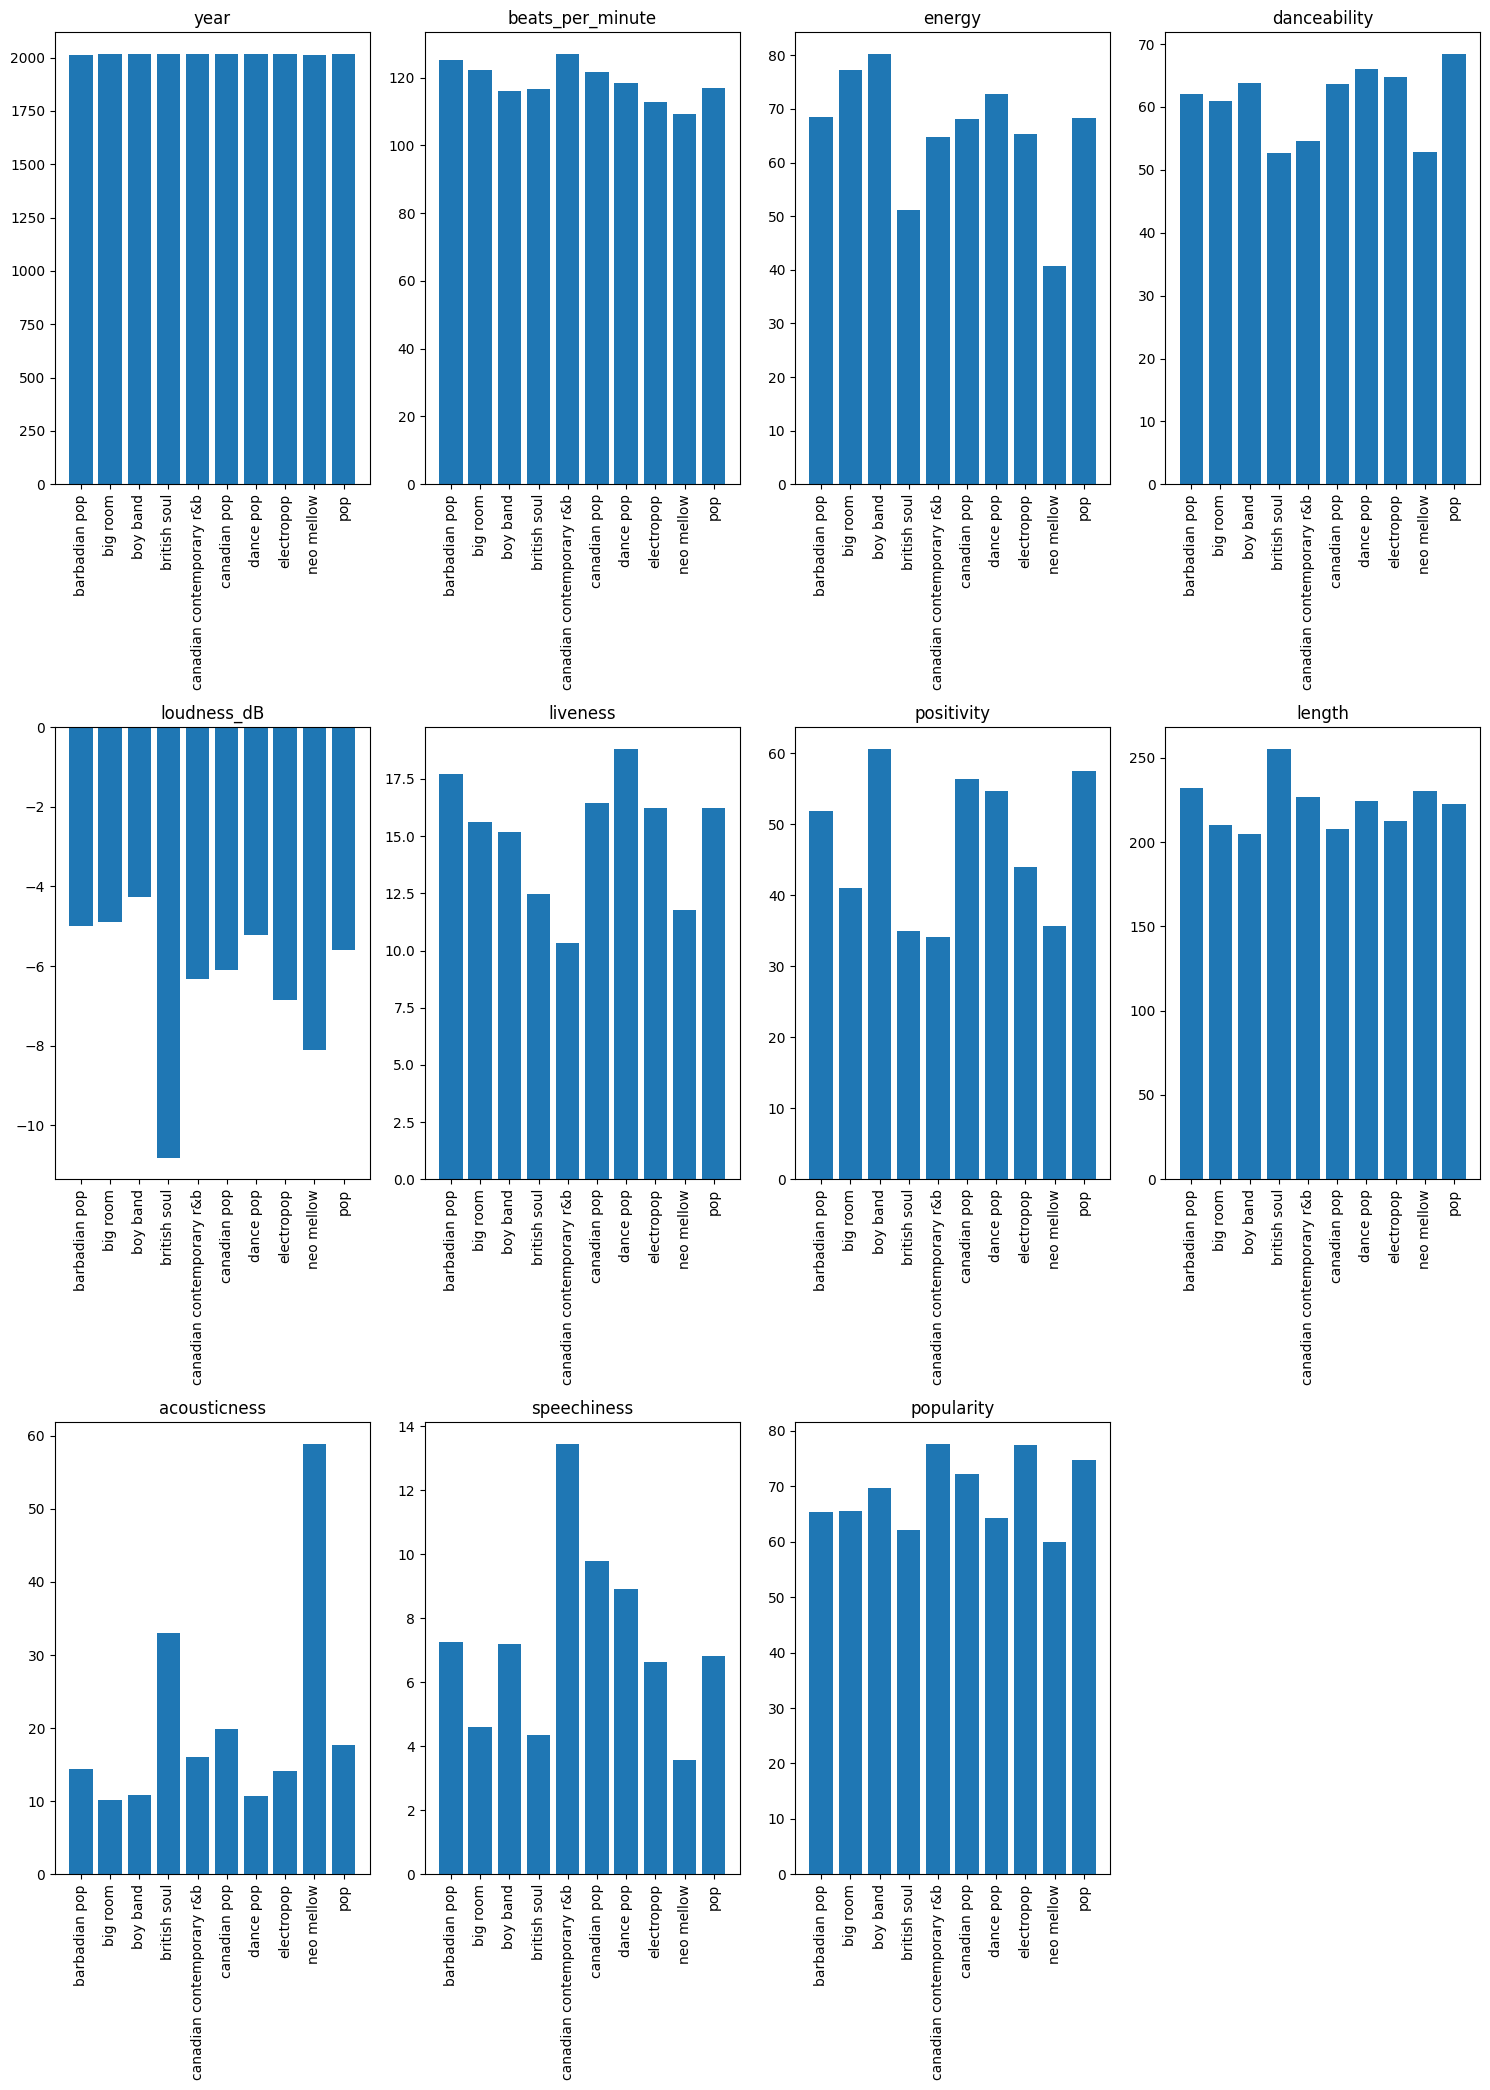

In [16]:
# Selecciona solament les files dels 10 generes mes comuns
df_top_genres = df[df['top_genre'].isin(most_used.index)]

# Agrupo per genere per fer la mitjana
grouped = df_top_genres.groupby("top_genre").mean()

# Figura amb els subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 21))

for i, col in enumerate(grouped.columns):
    # Selecciono el subplot adequat
    ax = axs[i // 4][i % 4]

    # Grafic de barres
    ax.bar(grouped.index, grouped[col])

    # Etiquetes
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=90)

# Elimino el ultim subplot buit, si els grafics son impars (com es el cas)
if len(features) % 2 != 0:
    fig.delaxes(axs[-1, -1])

fig.tight_layout()
plt.show()

* Tots els generes, contenen aproximadament les mateixes pulsacions per minut.
* El neo mellow i british soul són els generes menys energètics.
* Tots són bastant ballables, sent els dos anteriors els que menys.
* El més sonor és el british soul, seguit del neo mellow. És a dir, dos menys energètics i menys ballables són els més sonors.
* Les cançons més positives són les del gènere boy band, juntament amb dance pop i pop.
* El més acústic és el de neo mellow.
* Les cançons amb més lletra solen ser les que pertanyen al canadian contemporary r&b.

# 2. Preprocessing

Un cop realitzat el anàlisi, abans de tractar les dades. Faig el split de train i test, per tal d'assegurar que els processos de neteja i transformació de les dades es desenvolupin de manera independent. Aconseguint així, una avaluació realista del rendiment del model.

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((482, 14), (121, 14))

Abans de fer l'encoding elimino els duplicats i la columna 'title', ja que és irrellevant per determinar el gènere.

In [18]:
# Elimincio dels duplicats
train_df.drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True)

# Eliminacio titol
train_df.drop('title', axis=1, inplace=True)
test_df.drop('title', axis=1, inplace=True)

# Tracto el outlier del bpm, com sols hi ha un valor el substitueixo per la mitjana
train_df.beats_per_minute = train_df.beats_per_minute.replace(0,
                              train_df.beats_per_minute.mean())
test_df.beats_per_minute = test_df.beats_per_minute.replace(0,
                              test_df.beats_per_minute.mean())

train_df.shape, test_df.shape

((471, 13), (121, 13))

In [19]:
# Defineixo el estil general de cada subgenere
genres_dict = {
    'pop': ['pop', 'neo mellow', 'boy band'],
    'r&b': ['r&b', 'british soul'],
    'hip hop': ['hip hop', 'chicago rap'],
    'edm': ['edm', 'electro', 'house', 'brostep', 'big room', 'complextro',
            'downtempo'],
    'indie': ['indie', 'permanent wave'],
    'latin': ['latin'],
}

# Canvio els generes similars amb els estils del diccionari
train_df['top_genre'] = train_df['top_genre'].apply(lambda x: next(
    (k for k, v in genres_dict.items() if any(s in x for s in v)), x))
test_df['top_genre'] = test_df['top_genre'].apply(lambda x: next(
    (k for k, v in genres_dict.items() if any(s in x for s in v)), x))

train_df["top_genre"].value_counts()

pop                        399
edm                         27
r&b                         16
hip hop                     12
australian dance             5
latin                        4
indie                        3
escape room                  2
hollywood                    1
celtic rock                  1
irish singer-songwriter      1
Name: top_genre, dtype: int64

In [20]:
# Elimino els generes que apareixen menys de dos cops en el dataset
genres_to_eliminate = ['escape room', 'hollywood', 'celtic rock',
                       'irish singer-songwriter', 'contemporary country']
train_df = train_df[~train_df['top_genre'].isin(genres_to_eliminate)]
test_df = test_df[~test_df['top_genre'].isin(genres_to_eliminate)]

train_df["top_genre"].value_counts()

pop                 399
edm                  27
r&b                  16
hip hop              12
australian dance      5
latin                 4
indie                 3
Name: top_genre, dtype: int64

In [21]:
# Instancies de LabelEncoder per cada categoria de train i test
lab_artist = LabelEncoder()
lab_top_genre = LabelEncoder()

# Encoding
train_df['artist'] = lab_artist.fit_transform(train_df['artist'])
train_df['top_genre'] = lab_top_genre.fit_transform(train_df['top_genre'])
test_df['artist'] = lab_artist.fit_transform(test_df['artist'])
test_df['top_genre'] = lab_top_genre.fit_transform(test_df['top_genre'])

# Equivalencies
artist_equivalence = dict(zip(lab_artist.classes_,
                              lab_artist.transform(lab_artist.classes_)))
top_genre_equivalence = dict(zip(lab_top_genre.classes_,
                              lab_top_genre.transform(lab_top_genre.classes_)))

# Dataframe per les equivalencies
artist_equivalence_df = pd.DataFrame(list(artist_equivalence.items()),
                                     columns=['artist', 'Encoded Value'])
top_genre_equivalence_df = pd.DataFrame(list(top_genre_equivalence.items()),
                                     columns=['top_genre', 'Encoded Value'])

print("\nEquivalencies de 'artist':")
print(artist_equivalence_df.to_string(index=False))
print("\nEquivalencies de 'top_genre':")
print(top_genre_equivalence_df.to_string(index=False))


Equivalencies de 'artist':
                 artist  Encoded Value
                  Adele              0
           Alessia Cara              1
                 Alesso              2
          Austin Mahone              3
                 Avicii              4
          Avril Lavigne              5
         Britney Spears              6
             Bruno Mars              7
          Calvin Harris              8
       Carly Rae Jepsen              9
           Cashmere Cat             10
            Chris Brown             11
     Christina Aguilera             12
               Coldplay             13
                   DNCE             14
           David Guetta             15
            Demi Lovato             16
             Ed Sheeran             17
         Ellie Goulding             18
            Emeli Sandé             19
       Enrique Iglesias             20
                 Fergie             21
               Flo Rida             22
 Florence + The Machine             

In [22]:
# Correlacions amb el target
train_corr = train_df.corr()
test_corr = test_df.corr()

corr_df = pd.DataFrame(train_corr['top_genre'].sort_values(ascending=False))
corr_df.columns = ['Correlations']

corr_df

,Correlations
top_genre,1.000000
positivity,0.079926
liveness,0.066714
beats_per_minute,0.044885
acousticness,0.038353
danceability,0.028622
speechiness,-0.002260
length,-0.025289
popularity,-0.037403
loudness_dB,-0.049539


Elimino les features year i artist, ja que tenen una relació feble amb el gènere.

In [23]:
train_df.drop('year', axis=1, inplace=True)
train_df.drop('artist', axis=1, inplace=True)
test_df.drop('year', axis=1, inplace=True)
test_df.drop('artist', axis=1, inplace=True)

print(train_df.head())
print('\n',train_df.shape, test_df.shape)

     top_genre  beats_per_minute  energy  danceability  loudness_dB  liveness  \
9            5             126.0      72            79           -4         7   
426          5             122.0      78            60           -5        19   
525          5              92.0      81            65           -4        17   
188          5             138.0      68            61           -7        43   
131          5             120.0      80            68           -6        13   

     positivity  length  acousticness  speechiness  popularity  
9            61     235            13            4          73  
426          53     208            16            5          52  
525          55     211            19            5          80  
188          49     424             1           24          58  
131          78     211             3            4          65  

 (466, 11) (120, 11)


Donada la diferència d'escales entre les característiques, normalitzo les dades perquè els models no siguin perceptibles als valors amb rangs més grans.

In [24]:
# Divideixo les dades x i y
X_train = train_df.values[:,1:]
y_train = train_df.values[:,0]
X_test = test_df.values[:,1:]
y_test = test_df.values[:,0]

# Normalitzo les caracteristiques
scaler = StandardScaler().fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

X_train_st, X_test_st

(array([[ 3.08404434e-01,  8.63887187e-02,  1.03999087e+00, ...,
         -3.53493881e-02, -5.82207407e-01,  4.66817755e-01],
        [ 1.43250576e-01,  4.55156440e-01, -3.68833971e-01, ...,
          1.13501348e-01, -4.53686018e-01, -1.00729601e+00],
        [-1.09540336e+00,  6.39540301e-01,  1.90940796e-03, ...,
          2.62352085e-01, -4.53686018e-01,  9.58189009e-01],
        ...,
        [ 8.86442937e-01, -7.12608011e-01, -1.48106411e+00, ...,
         -4.32284686e-01, -7.10728796e-01,  8.87993116e-01],
        [-1.13669182e+00, -9.79951420e-02,  7.43396167e-01, ...,
          6.09670470e-01, -5.82207407e-01, -1.77945084e+00],
        [ 2.25827505e-01,  7.62462874e-01, -7.22392679e-02, ...,
          1.42675241e-02, -4.53686018e-01, -2.90258513e+00]]),
 array([[ 0.06067365, -0.7740693 ,  0.96584219, ..., -0.63075233,
         -0.58220741,  0.67740544],
        [-0.55865332,  0.94684674,  0.37265279, ..., -0.58113542,
          0.18892093,  0.81779722],
        [ 0.06067365, -0.

# 3. Metric selection

Per poder avaluar el problema, busco una mètrica d'avaluació adequada per classificar correctament els generes:

* **Accuracy**: representa el percentatge total de valors correctament classificats.
* **Precision**: analitza que percentatge de valors que s'han classificat com a positius són positius.
* **F1 Score**: utilitzada quan el conjunt de dades està desbalancejat. Combina precision i recall per obtenir un valor més objectiu.

A més per visualitzar els models, utilitzaré les gràfiques PR i ROC Curve:

* **Precision Recall (PR)**: gràfica entre precision i recall. La corba ideal seria la que s'acosta al màxim a la cantonada superior dreta. És especialment útil per dades desequilibrades.
* **ROC Curve**: relaciona el recall amb els falsos positius, és a dir la sensibilitat del model amb les fallades optimistes. La corba ideal seria la que s'acosti més a la cantonada superior esquerra. Una àrea sota la corba (AUC) més gran indica un millor rendiment del model.

In [25]:
# Entreno la regressio logistica per veure com es comporten les metriques
model_lr = LogisticRegression()
model_lr.fit(X_train_st, y_train)

# Prediccions
y_pred_lr = model_lr.predict(X_test_st)
y_scores_lr = model_lr.predict_proba(X_test_st)[:,1]

# Calcul de les metriques a triar
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted',
                               zero_division= 0)
f1Score_lr = f1_score(y_test, y_pred_lr, average='weighted')

print("\nResultats: ")
print(f'Accuracy: {accuracy_lr:.4f}')
print(f'Precision: {precision_lr:.4f}')
print(f'F1 Score: {f1Score_lr:.4f}')


Resultats: 
Accuracy: 0.8667
Precision: 0.7596
F1 Score: 0.8076


Tot i tenir un millor resultat en l'accuracy, escullo el ***f1score***, ja que com s'ha vist les dades estan desequilibrades, hi ha moltes cançons pop en diferencia a la resta de classes. Per tant, l'accuracy pot portar resultats poc realistes, perquè podria estar classificant incorrectament les altres classes que no siguin majoritàries.

In [26]:
# Funcio per mostrar PR
def plot_precision_recall(models, y_test_param, class_labels):
    y_test_bin = label_binarize(y_test_param, classes=list(class_labels.values()))

    for name, y_scores in models.items():
        for i in range(len(class_labels)):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores if y_scores.ndim == 1 else y_scores[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_scores if y_scores.ndim == 1 else y_scores[:, i])
            plt.plot(recall, precision, lw=2, label=f'{list(class_labels.keys())[i]} (AP = {ap:.2f})')

    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title('Precision-Recall curve')
    plt.show()

# Funcio per mostrar ROC curve
def plot_roc_curve(models, y_test_param, class_labels):
    y_test_bin = label_binarize(y_test_param, classes=list(class_labels.values()))

    for name, y_scores in models.items():
        for i in range(len(class_labels)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores if y_scores.ndim == 1 else y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=list(class_labels.keys())[i] + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")
    plt.title('ROC curve')
    plt.show()

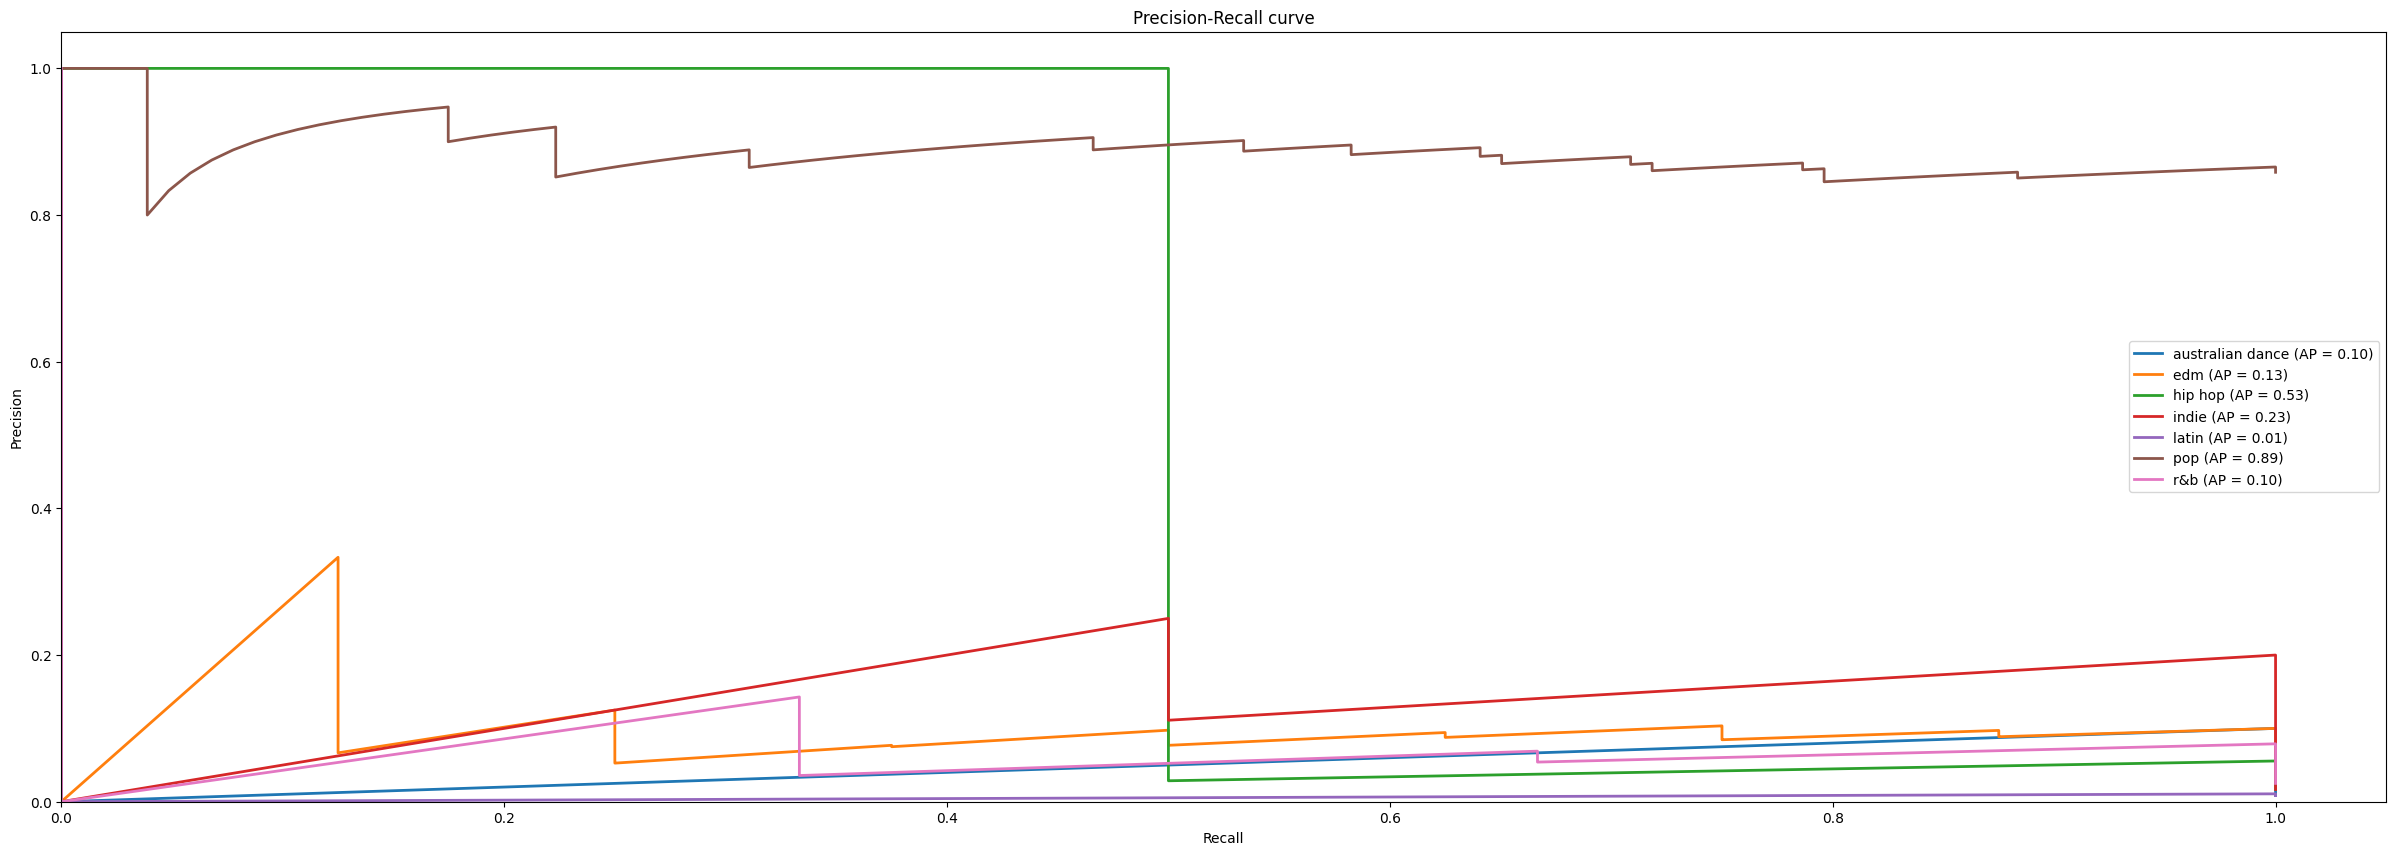

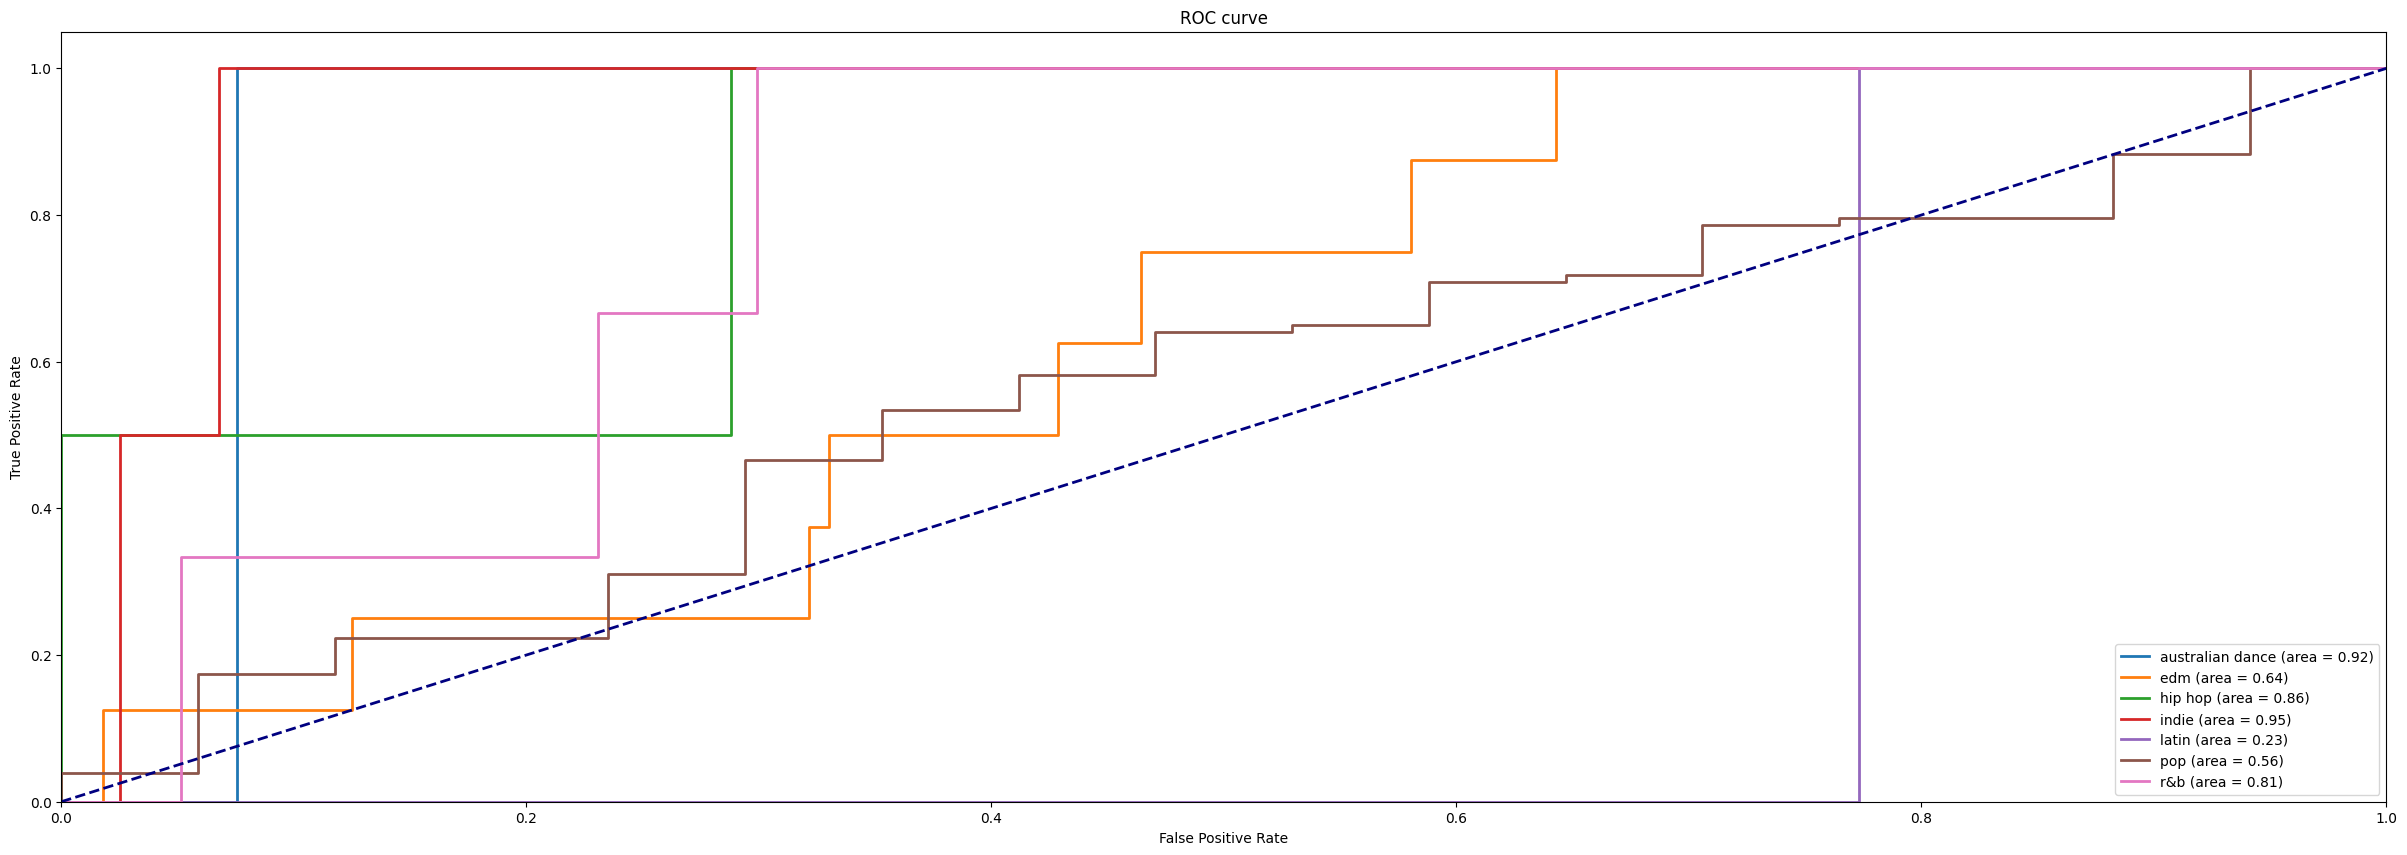

In [27]:
# Primera visualitzacio de les curves per la regressio
y_scores_lr = model_lr.predict_proba(X_test_st)
plot_precision_recall({'Logistic Regression': y_scores_lr}, y_test, top_genre_equivalence)
plot_roc_curve({'Logistic Regression': y_scores_lr}, y_test, top_genre_equivalence)

# 4. Model selection

Utilitzaré aquests models per escollir el que millor s'ajusti al problema mitjançant la validació creuada.
* **Regressió Logística**
* **Random Forest**
* **KNN**
* **SVM**
* **XGBoost**
* **Gradient Boosting**
*  **Light Gradient Boosting Machine**
* **Ada Boost**
* **Decision Tree**

In [28]:
# Defineixo els models
models = {
    'Regressió Logística': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Defineixo els paràmetres generics per fer una primera aproximacio i buscar el millor model
params = {
    'Regressió Logística': { 'C': [0.001, 0.01, 0.1, 1, 10, 100] },
    'Random Forest': { 'n_estimators': [10, 50, 100], 'max_depth': [5, 10, None] },
    'KNN': { 'n_neighbors': [3, 5, 7, 9] },
    'SVM': { 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'] },
    'XGBoost': { 'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1] },
    'Gradient Boosting': { 'n_estimators': [50, 100, 200],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10] },
    'LightGBM': { 'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1] },
    'Ada Boost': { 'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1] },
    'Decision Tree': { 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5] }
}

In [ ]:
# Defineixo l'objecte KFold per a la validació creuada
kf = KFold(n_splits=10)

# Defineixo el scorer seleccionat anteriorment
scorer = make_scorer(f1_score, average='weighted')

# Escolleixo els millors hiperparàmetres per a cada model
res = {}
for name, model in models.items():
    param = params[name]
    gs = GridSearchCV(model, param, cv=kf, scoring = scorer)

    start_time = time.time()
    gs.fit(X_train_st, y_train)
    end_time = time.time()

    elapsed_time = end_time - start_time
    pred = gs.predict(X_test_st)

    res[name] = (gs.best_score_, f1_score(y_test, pred, average='weighted'), gs.best_params_, elapsed_time)

In [30]:
# Mostro els resultats de cada model (ordenats de millor a pitjor segons train i test)
def show_scores(res_param):
  tableRes = dict(sorted(res_param.items(), key=lambda item: item[1][0] + item[1][1], reverse=True))
  tableRes = pd.DataFrame(tableRes).transpose().rename(columns={0: 'TrainScore', 1: 'TestScore', 2: 'Params', 3: 'ElapsedTime(s)'})
  return tableRes

show_scores(res)

,TrainScore,TestScore,Params,ElapsedTime(s)
Gradient Boosting,0.800006,0.823313,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",474.417981
Random Forest,0.792765,0.823313,"{'max_depth': None, 'n_estimators': 10}",10.783638
LightGBM,0.798024,0.808971,"{'learning_rate': 0.01, 'n_estimators': 200}",39.720876
XGBoost,0.794849,0.7929,"{'learning_rate': 0.01, 'n_estimators': 50}",17.211958
Regressió Logística,0.791445,0.794977,{'C': 10},1.787093
SVM,0.790609,0.7929,"{'C': 0.1, 'gamma': 'scale'}",2.913555
Ada Boost,0.790609,0.7929,"{'learning_rate': 0.01, 'n_estimators': 50}",16.626934
KNN,0.791573,0.78454,{'n_neighbors': 5},0.2994
Decision Tree,0.777116,0.776027,"{'max_depth': 5, 'min_samples_split': 5}",0.293194


Els scores són bastant semblants, però estudiaré millor els dos primers. Probablement, utilitzi el Random Forest, ja que el Gradient tarda massa i els resultats són pràcticament idèntics entre ells.

In [85]:
# Ampliacio del rang d'hiperparametres per Random Forest
rf_params_r = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(3, 7),
    'min_samples_split': randint(2, 10)
}

rf = RandomForestClassifier()

rf_random_search = RandomizedSearchCV(rf, rf_params_r, n_iter=32, cv=10, random_state=42)

start_time_random = time.time()
rf_random_search.fit(X_train_st, y_train)
end_time_random = time.time()

elapsed_time_random = end_time_random - start_time_random

pred_rf = rf_random_search.predict(X_test_st)

res_rf = {}
res_rf['Random Forest'] = (rf_random_search.best_score_, f1_score(y_test, pred_rf, average='weighted'), rf_random_search.best_params_, elapsed_time_random)
show_scores(res_rf)

,TrainScore,TestScore,Params,ElapsedTime(s)
Random Forest,0.85629,0.7929,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",79.80171


In [32]:
# Ampliacio del rang d'hiperparametres per Gradient Boosting
gb_params_r = {
    'n_estimators': randint(10, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 7)
}

gb = GradientBoostingClassifier()

gb_random_search = RandomizedSearchCV(gb, gb_params_r, n_iter=32, cv=10, random_state=42)

start_time_random = time.time()
gb_random_search.fit(X_train_st, y_train)
end_time_random = time.time()

elapsed_time_gb = end_time_random - start_time_random

pred_gb = gb_random_search.predict(X_test_st)

res_gb = {}
res_gb['Gradient Boosting'] = (gb_random_search.best_score_, f1_score(y_test, pred_gb, average='weighted'), gb_random_search.best_params_, elapsed_time_gb)
show_scores(res_gb)

,TrainScore,TestScore,Params,ElapsedTime(s)
Gradient Boosting,0.843386,0.817318,"{'learning_rate': 0.0823076398078035, 'max_dep...",541.977608


# 5. Anàlisi final

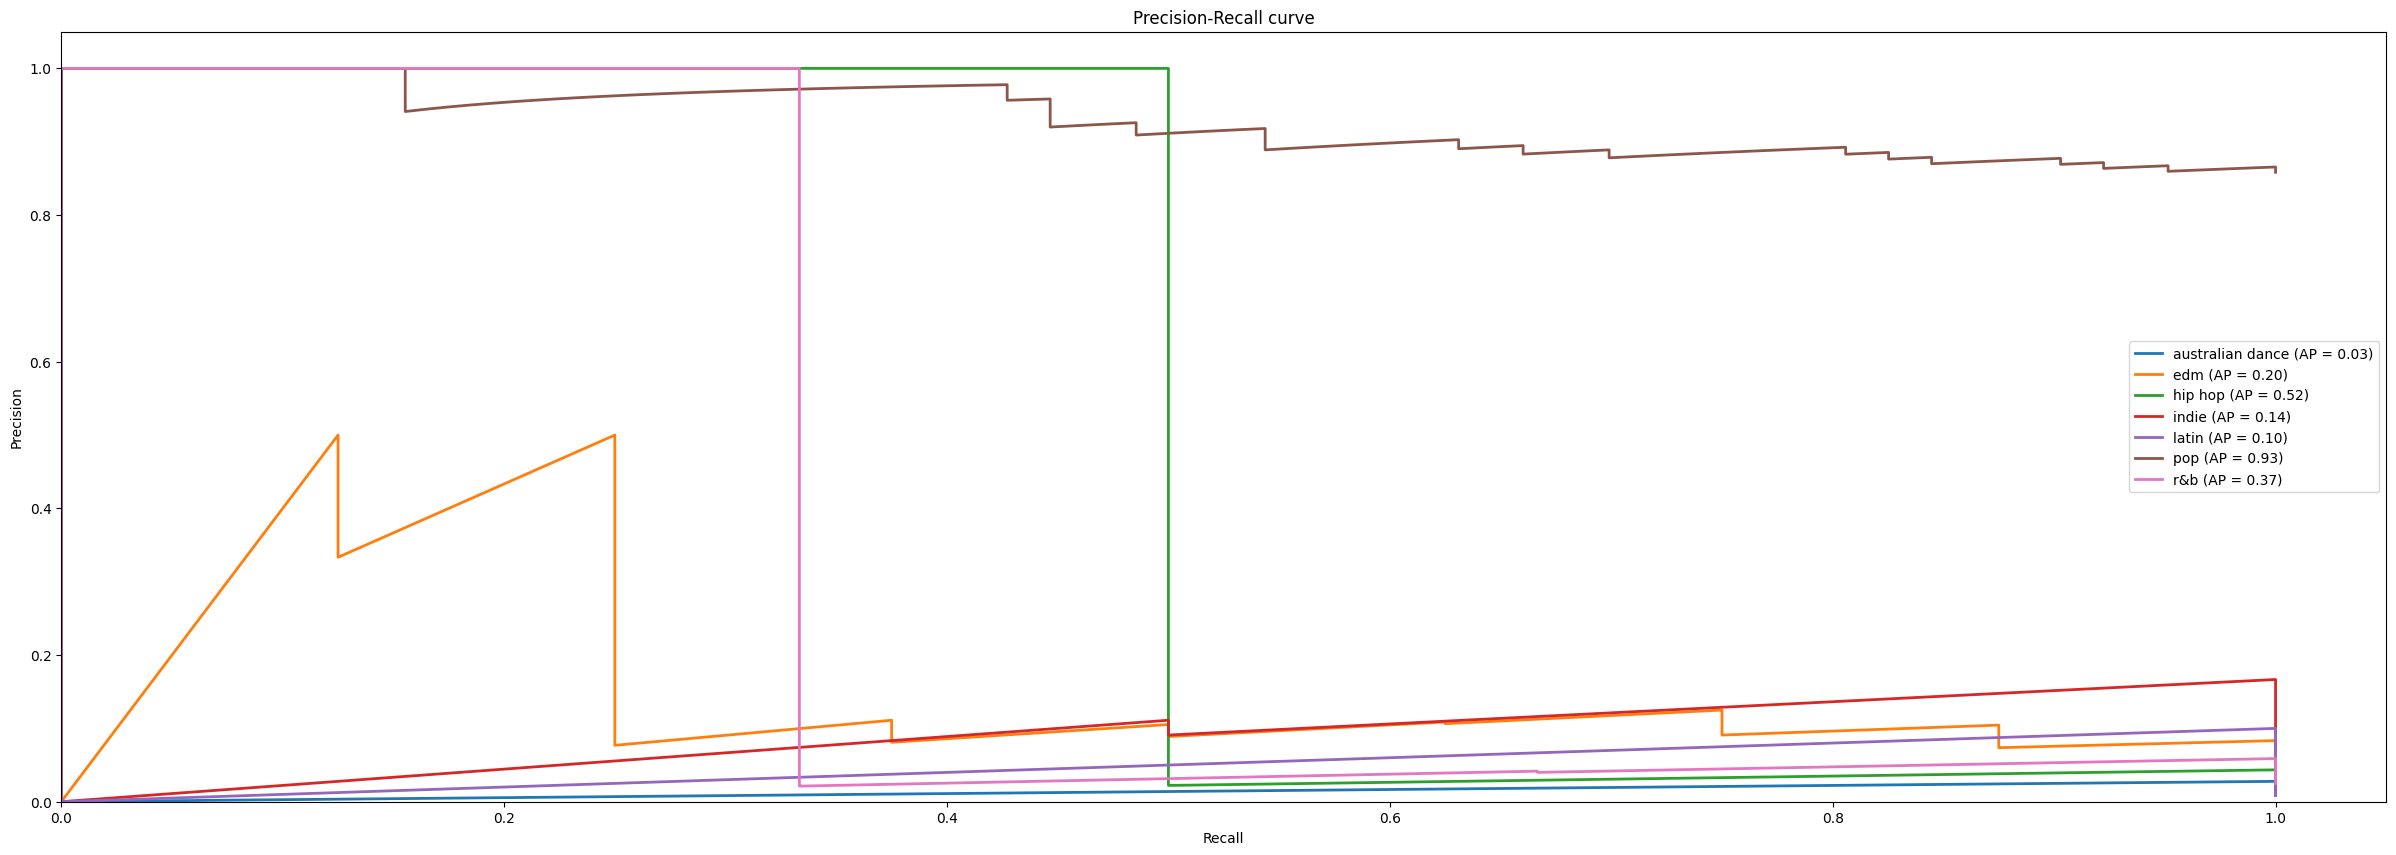

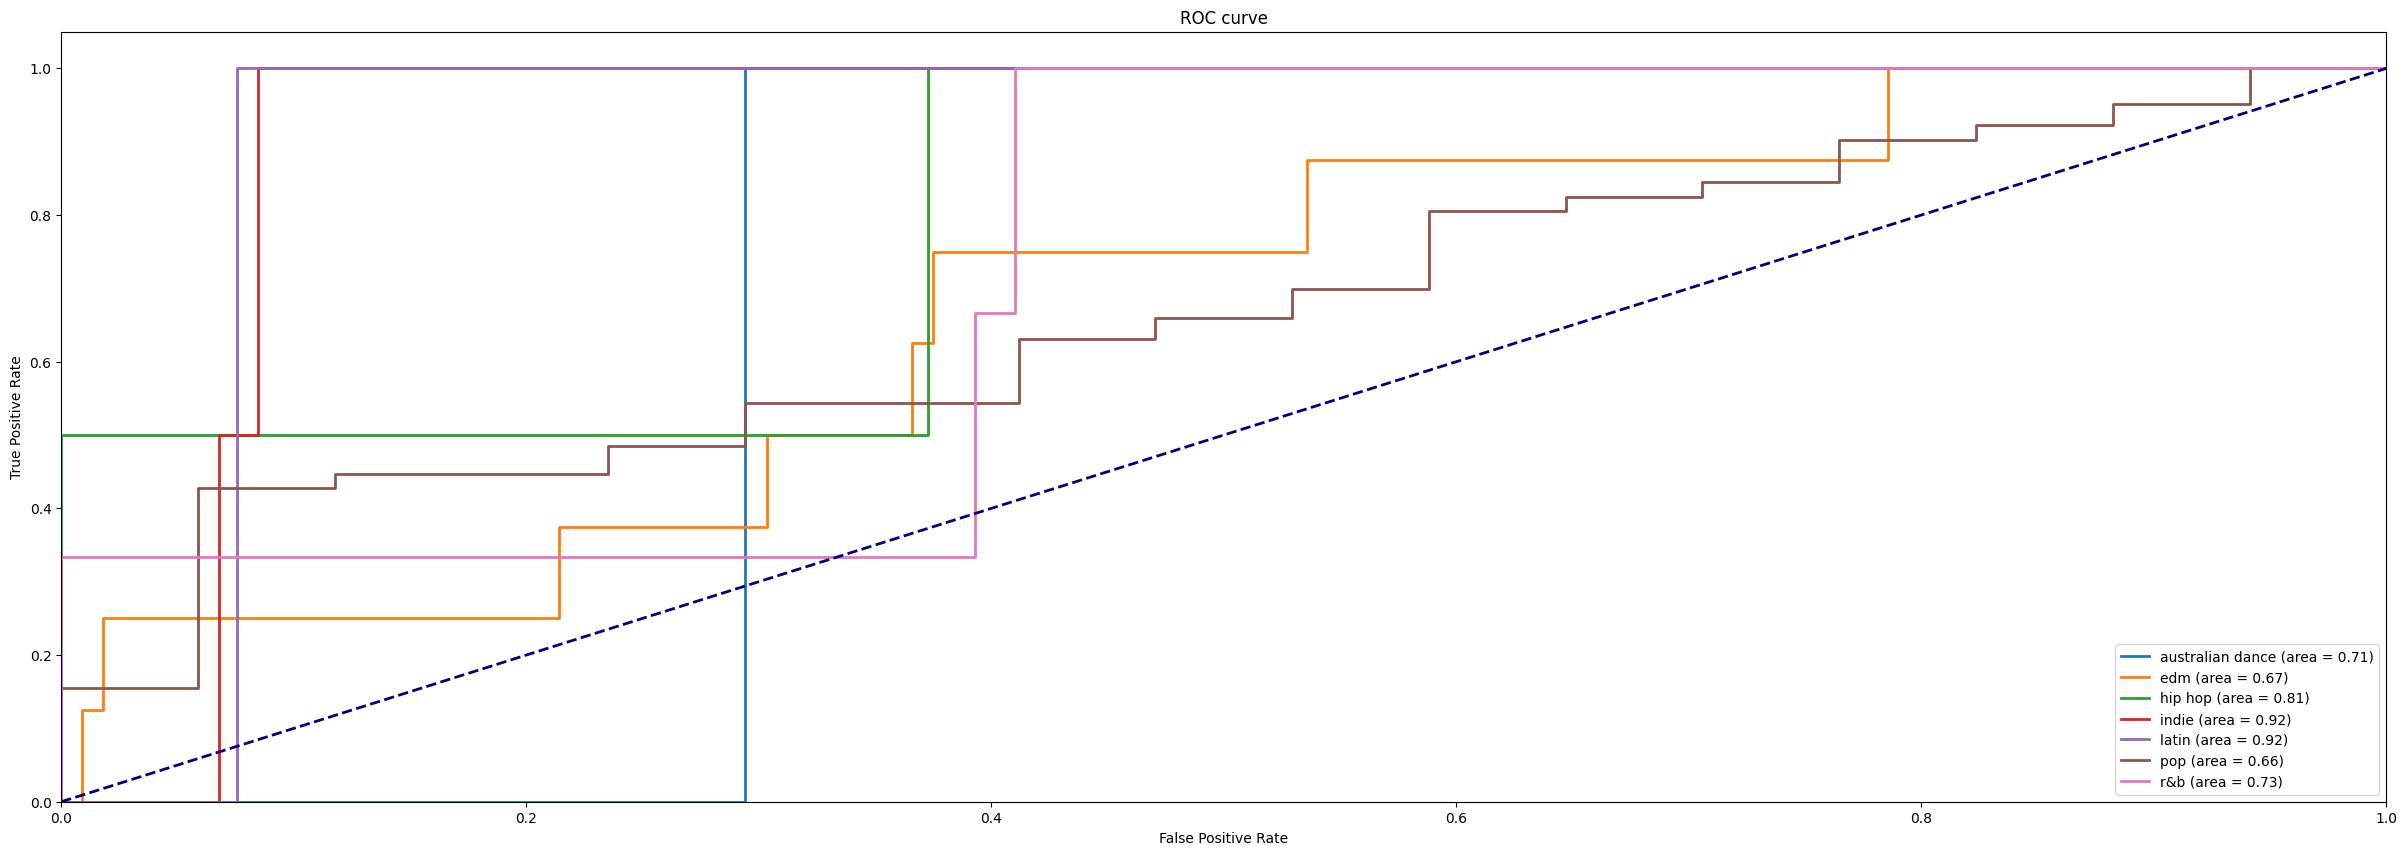

In [33]:
# Random Forest PR i ROC
y_scores_rf = rf_random_search.predict_proba(X_test_st)
plot_precision_recall({'Random Forest': y_scores_rf}, y_test, top_genre_equivalence)
plot_roc_curve({'Random Forest': y_scores_rf}, y_test, top_genre_equivalence)

In [84]:
y_scores_tr = rf_random_search.predict_proba(X_test_st)

y_test_bin_tr = label_binarize(y_test, classes=list(top_genre_equivalence))
optimal_thresholds = []
i=0
for name, eq in top_genre_equivalence.items():
    precision, recall, thresholds = precision_recall_curve(y_test_bin_tr[:, i], y_scores_tr[:, i])
    optimal_idx = np.argmax(np.sqrt(precision * recall))
    optimal_thresholds.append(thresholds[optimal_idx])
    print(f'Optimal threshold for {name}: {thresholds[optimal_idx]}')
    i+=1

def apply_thresholds(y_scores_original, thresholds):
    y_pred_threshold = np.zeros_like(y_scores_original)
    for i in range(y_scores_original.shape[1]):
        y_pred_threshold[:, i] = (y_scores_original[:, i] > thresholds[i]).astype(int)
    return y_pred_threshold

Optimal threshold for australian dance: 0.0003972855731649701
Optimal threshold for edm: 0.011747876982680771
Optimal threshold for hip hop: 0.0012322147134138123
Optimal threshold for indie: 0.0
Optimal threshold for latin: 0.0
Optimal threshold for pop: 0.11233646925970786
Optimal threshold for r&b: 0.01536071344739908


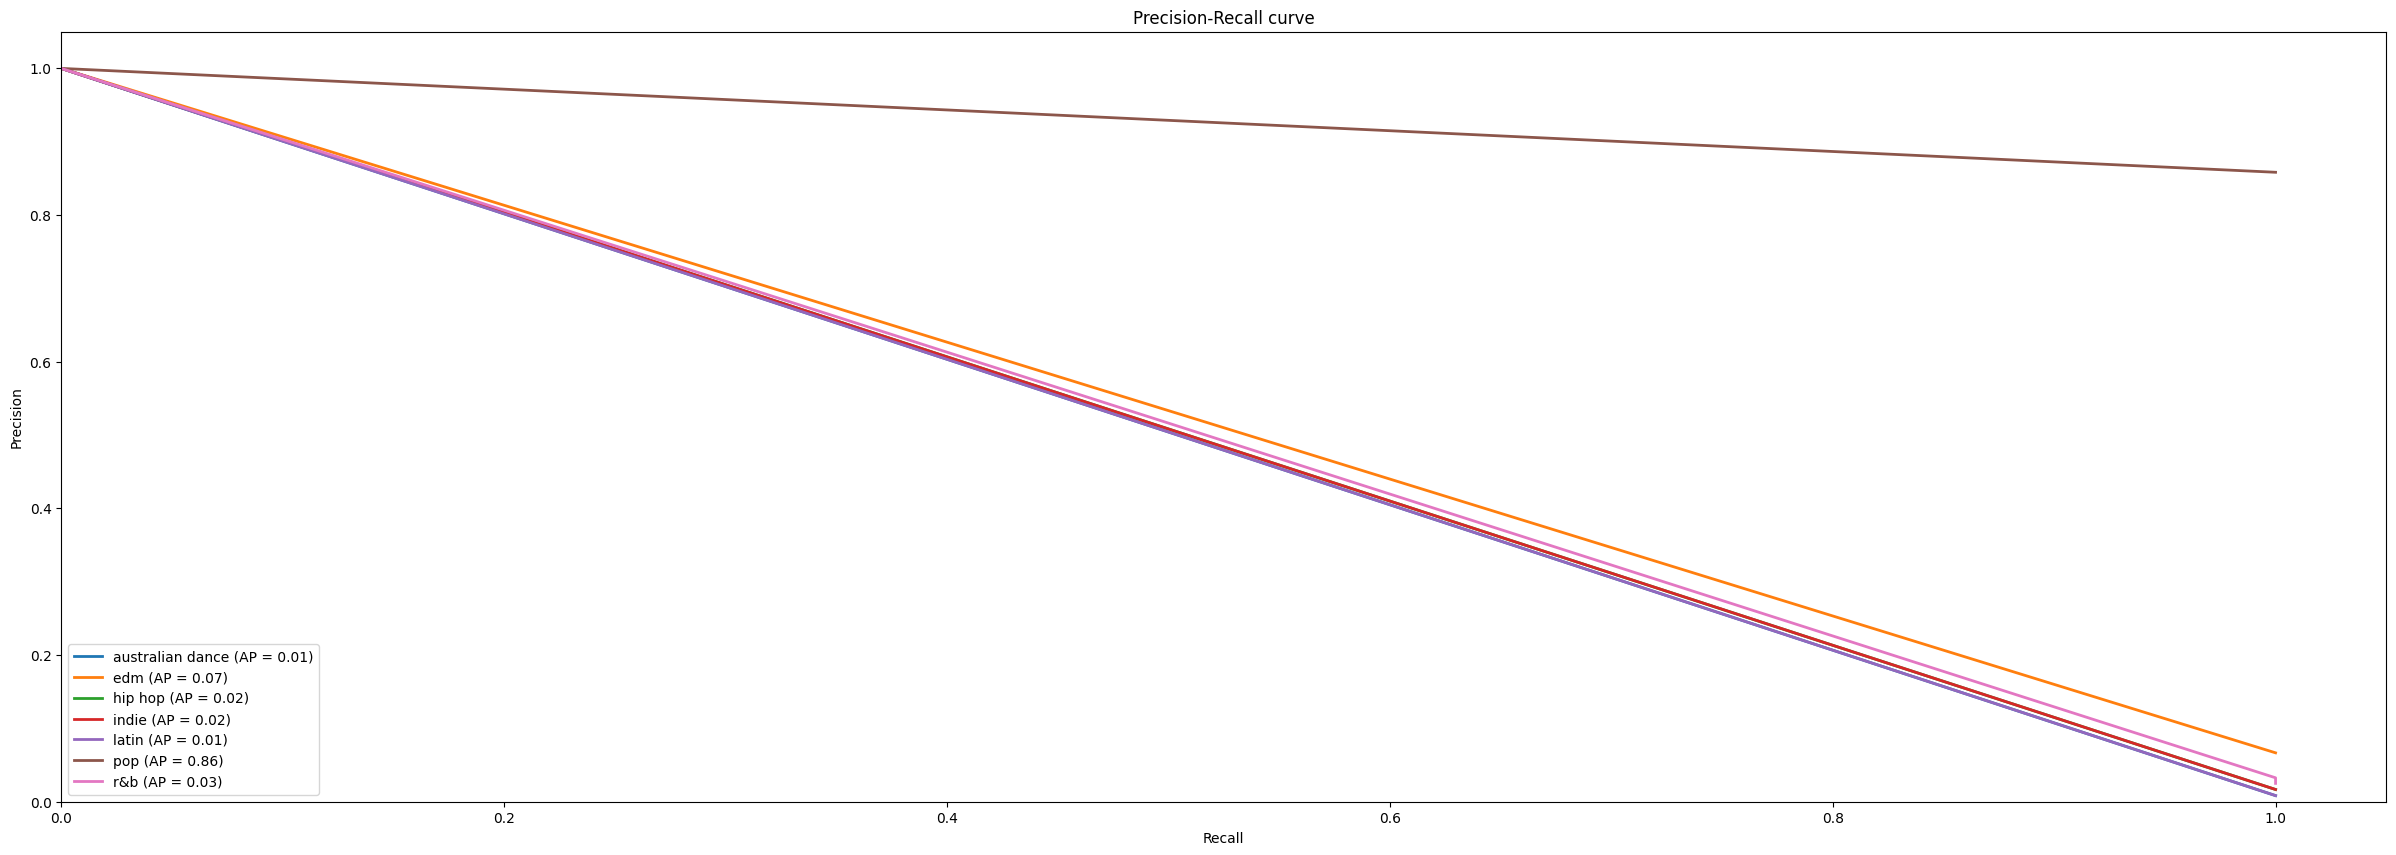

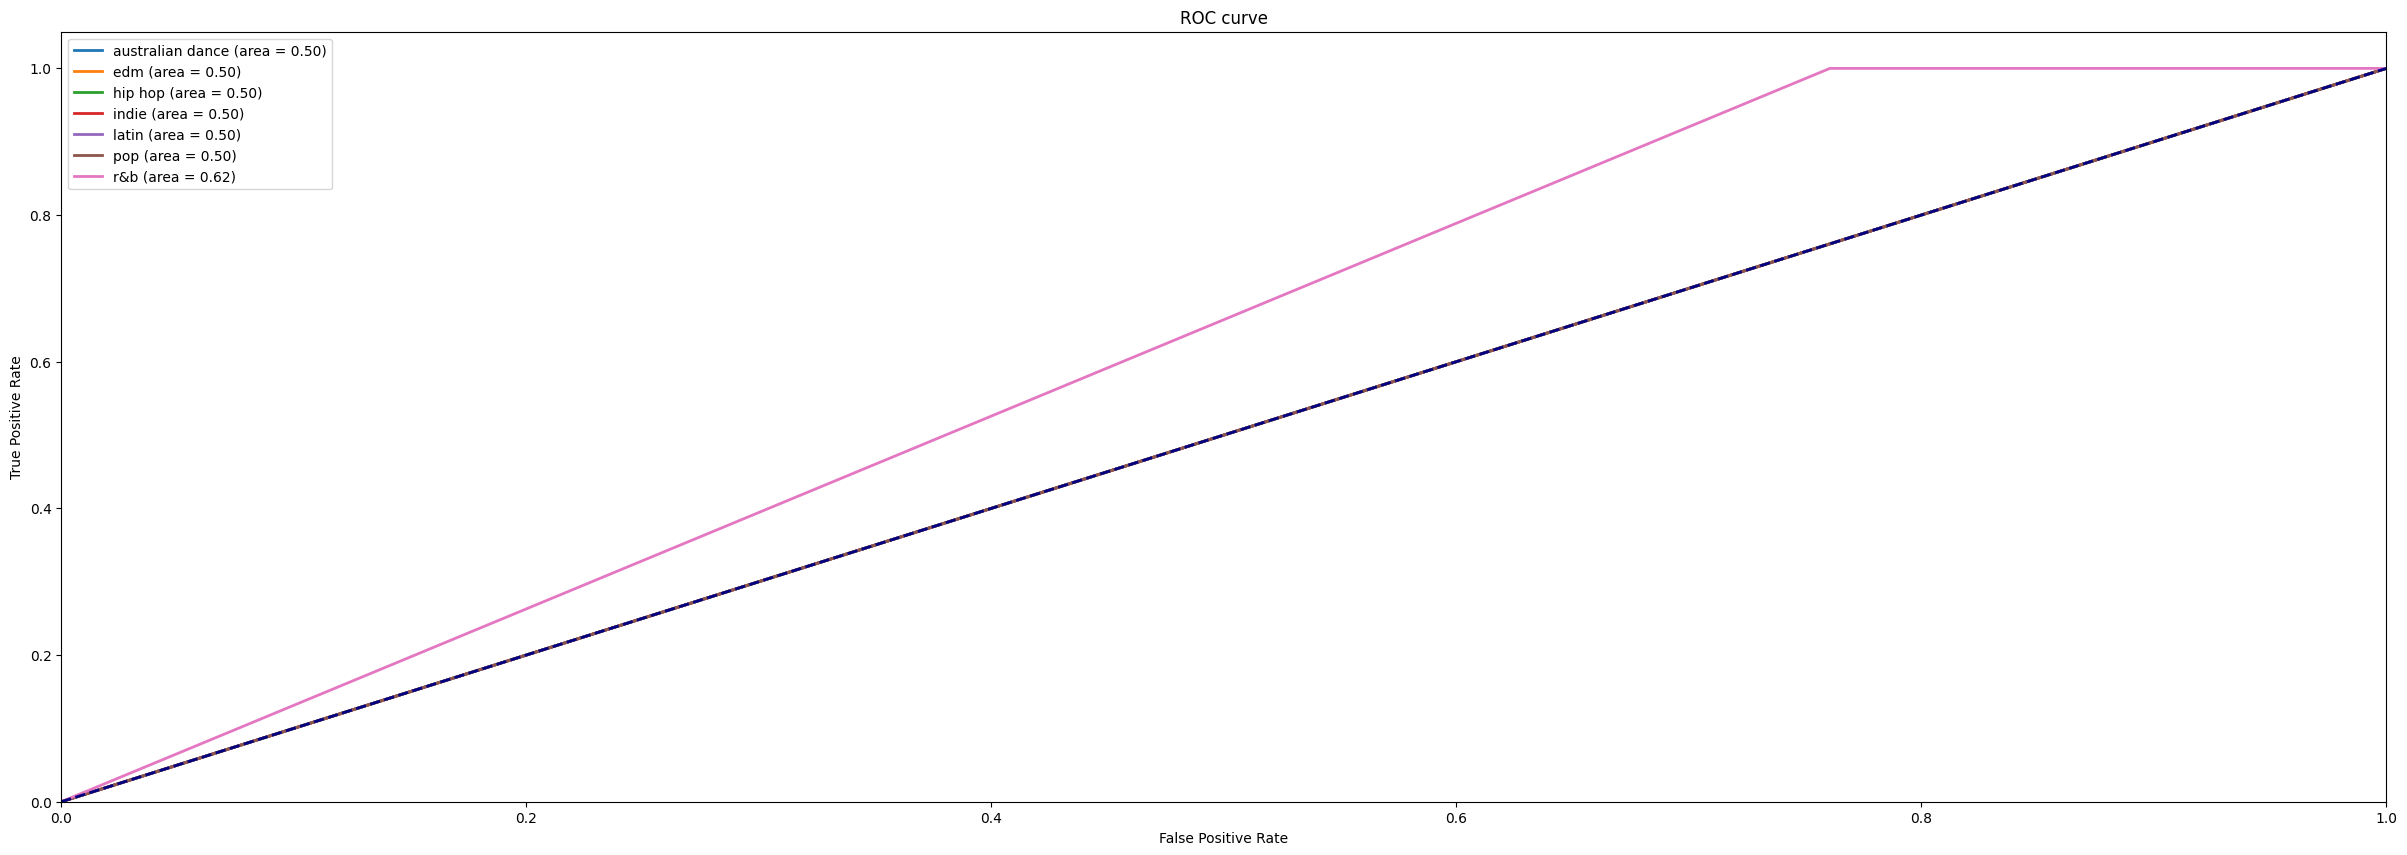

In [86]:
y_pred = apply_thresholds(y_scores_rf, optimal_thresholds)
plot_precision_recall({'Random Forest': y_pred}, y_test, top_genre_equivalence)
plot_roc_curve({'Random Forest': y_pred}, y_test, top_genre_equivalence)

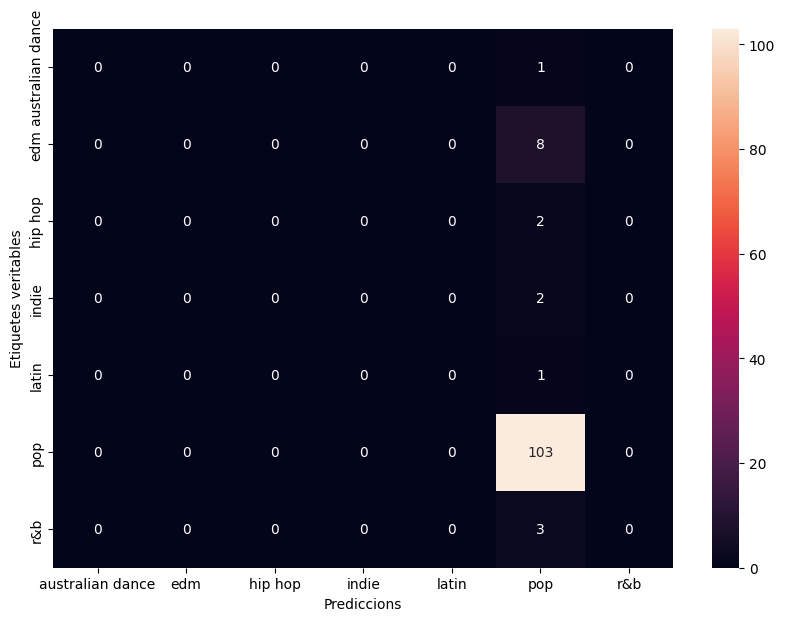

In [37]:
inv_top_genre_equivalences = {v: k for k, v in top_genre_equivalence.items()}

# Transormo els numeros en etiquetes
y_test_names = [inv_top_genre_equivalences[i] for i in y_test]
pred_rf_names = [inv_top_genre_equivalences[i] for i in pred_rf]

# Calcul la matriu de confusio
matrix = confusion_matrix(y_test_names, pred_rf_names)

# Crea un DataFrame para visualizar mejor la matriz de confusión
df_matrix = pd.DataFrame(matrix, index=inv_top_genre_equivalences.values(),
                         columns=inv_top_genre_equivalences.values())

# Visualizacio
plt.figure(figsize=(10,7))
sns.heatmap(df_matrix, annot=True, fmt='d')
plt.xlabel('Prediccions')
plt.ylabel('Etiquetes veritables')
plt.show()

In [81]:
# Trobo el minim d'instancies de les classes minoritaries
min_samples = min([sum(y_train == label) for label in top_genre_equivalence.values() if label != top_genre_equivalence['pop']])
k_neighbors = min(min_samples - 1, 5)

# Oversampling de totes les classes menys la predominant 'pop'
smote = SMOTE(sampling_strategy={label: 400 for label in top_genre_equivalence.values() if label != top_genre_equivalence['pop']}, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Normalitzo la nova mostra
X_train_res_st = scaler.transform(X_train_res)


# Random Forest amb el oversampling realitzat
rf_params_r = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(3, 7),
    'min_samples_split': randint(2, 10)
}

rf_random_search_os = RandomizedSearchCV(rf, rf_params_r, n_iter=32, cv=10, random_state=42)

start_time_random_os = time.time()
rf_random_search_os.fit(X_train_res_st, y_train_res)
end_time_random_os = time.time()

elapsed_time_random_os = end_time_random_os - start_time_random_os

pred_rf_os = rf_random_search_os.predict(X_test_st)

res_rf_os = {}
res_rf_os['Random Forest'] = (rf_random_search_os.best_score_, f1_score(y_test, pred_rf, average='weighted'), rf_random_search_os.best_params_, elapsed_time_random_os)
show_scores(res_rf_os)

,TrainScore,TestScore,Params,ElapsedTime(s)
Random Forest,0.939273,0.746349,"{'max_depth': 6, 'min_samples_split': 8, 'n_es...",185.602399


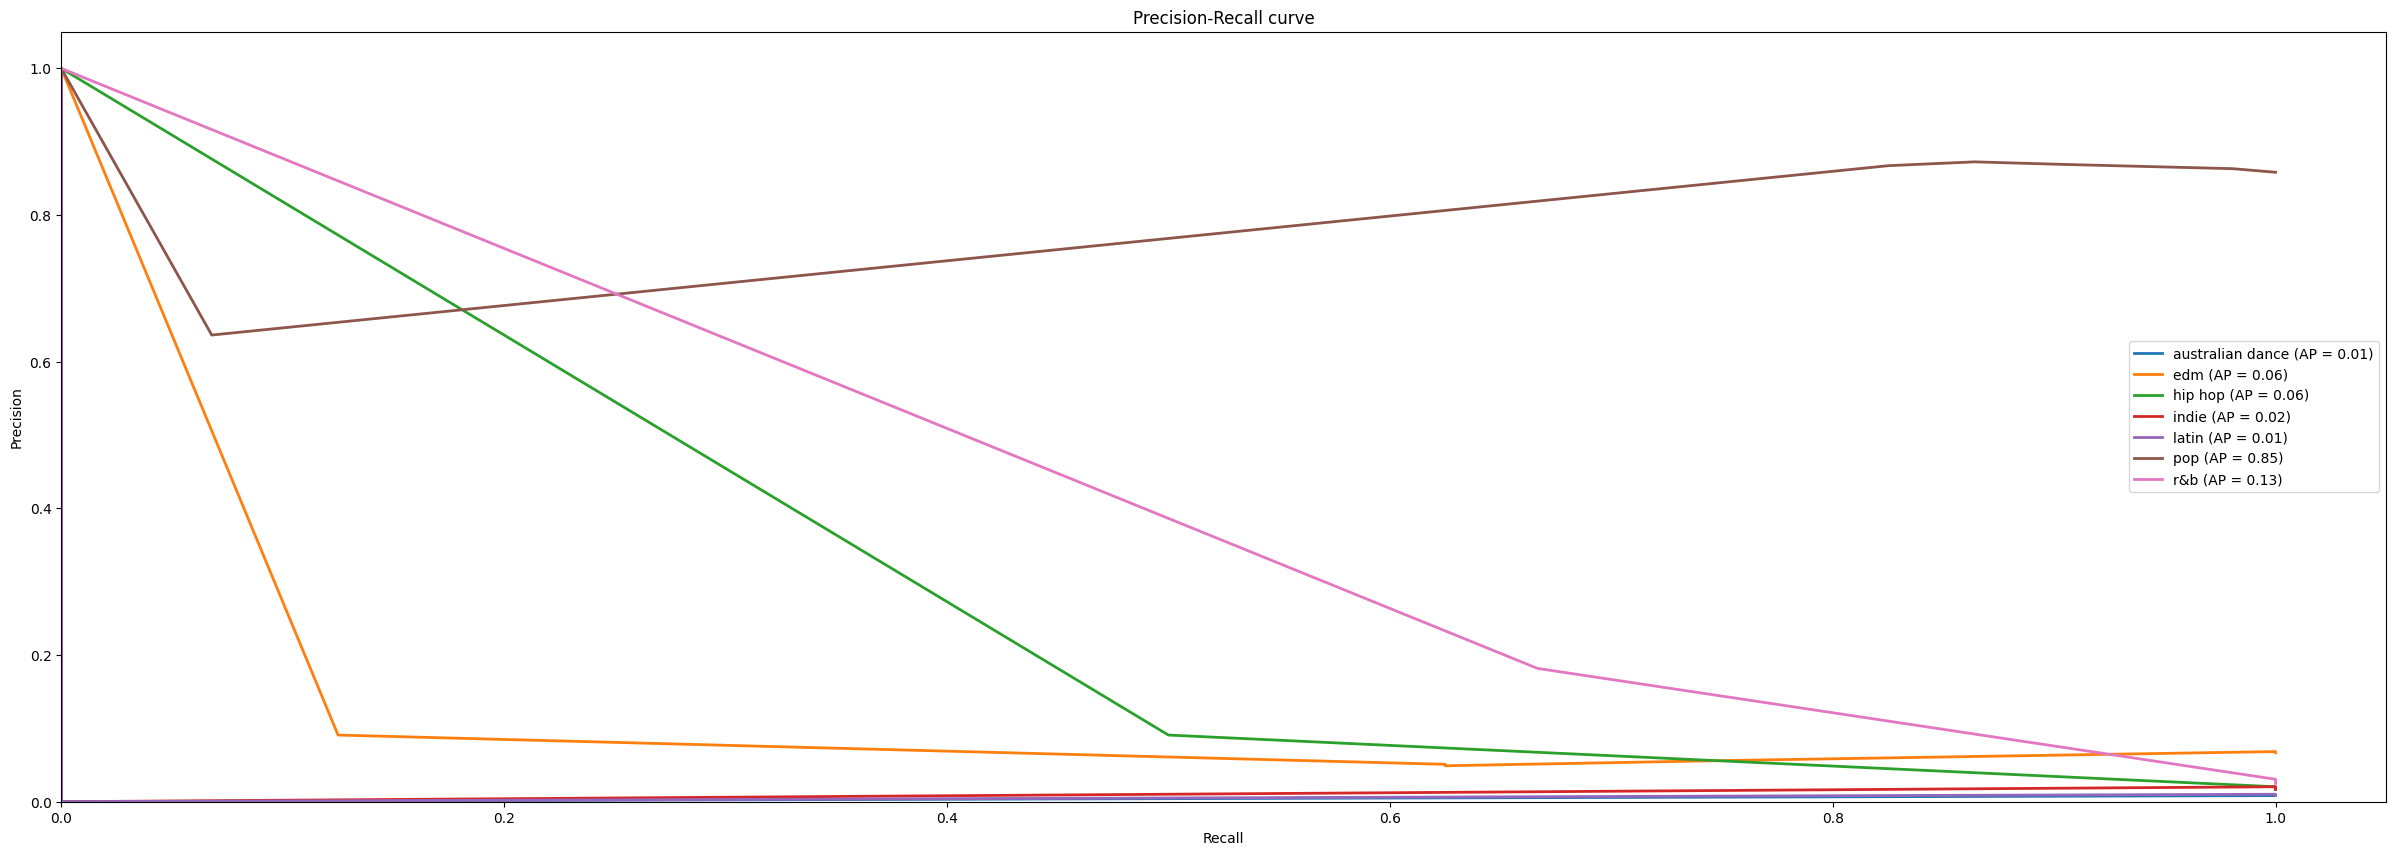

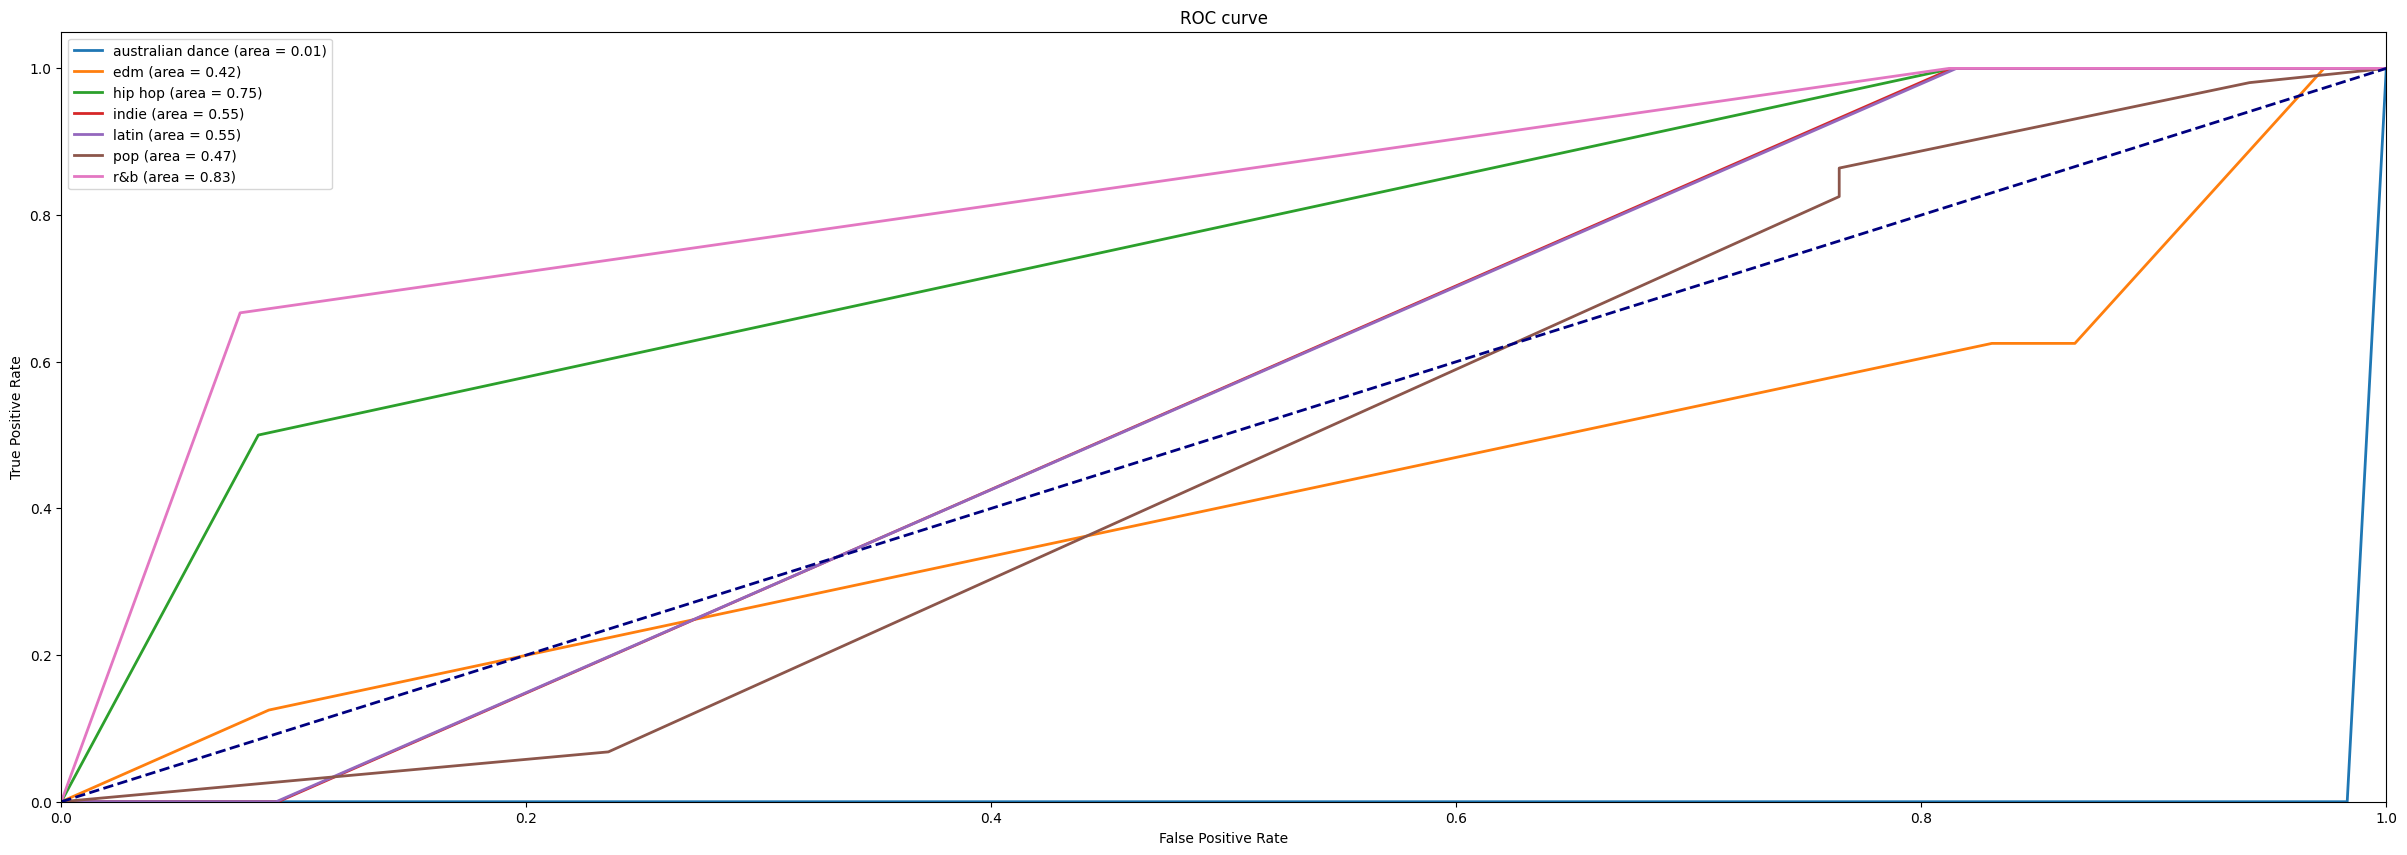

In [82]:
plot_precision_recall({'Random Forest': pred_rf_os}, y_test, top_genre_equivalence)
plot_roc_curve({'Random Forest': pred_rf_os}, y_test, top_genre_equivalence)

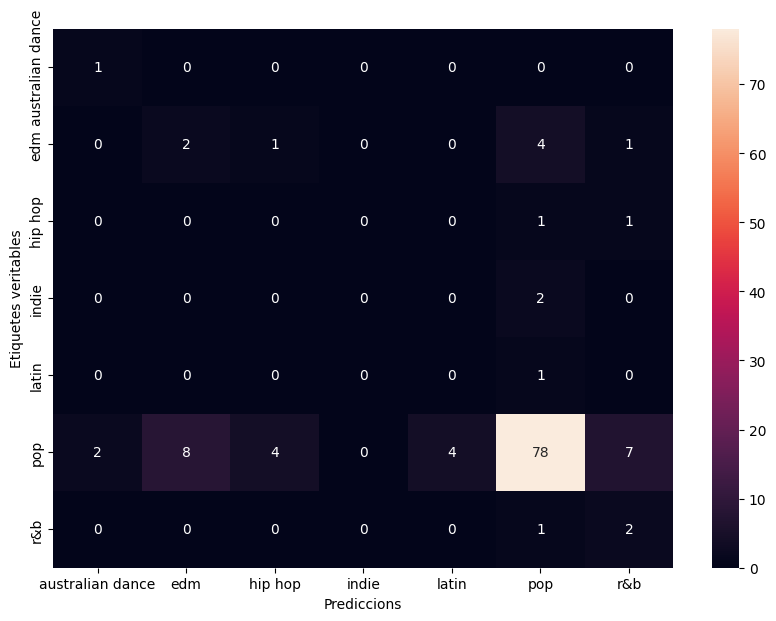

In [83]:
# Transormo els numeros en etiquetes
y_test_names_res = [inv_top_genre_equivalences[i] for i in y_test]
pred_rf_names_res = [inv_top_genre_equivalences[i] for i in pred_rf_os]

# Calcul la matriu de confusio
matrix_res = confusion_matrix(y_test_names_res, pred_rf_names_res)

# Crea un DataFrame para visualizar mejor la matriz de confusión
df_matrix_res = pd.DataFrame(matrix_res, index=inv_top_genre_equivalences.values(),
                         columns=inv_top_genre_equivalences.values())

# Visualizacio
plt.figure(figsize=(10,7))
sns.heatmap(df_matrix_res, annot=True, fmt='d')
plt.xlabel('Prediccions')
plt.ylabel('Etiquetes veritables')
plt.show()